In [1]:
%load_ext autoreload
%autoreload 2
from stock_prediction.etl.ticker_data_extractors import train_test_split
from stock_prediction.utils.series import get_normalized_nsteps_ahead_predictions_array
from stock_prediction.modeling.arima import UnivariateARIMAs
from stock_prediction.evaluation.analysis import summary_analysis
from stock_prediction.helpers.logging.log_config import get_logger
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd

logger = get_logger()

In [2]:
df_train, df_test = train_test_split()

## Definitions

In [3]:
w_size = 20
# We want to use at least half of the training data to fit
# the model on each TCV step so here we define the range on
# which to predict. Note that we also reject the last w_size
# points because we compute our prediction error on the w_size
# days at each time step
i_predict_min = df_train.shape[0] // 2
i_predict_max = df_train.shape[0] - w_size - 1

In [4]:
df_train_cumulative = (1 + df_train).cumprod()
actuals = get_normalized_nsteps_ahead_predictions_array(
    df=df_train_cumulative,
    n_steps_ahead=w_size,
    index_start=i_predict_min,
    index_end=i_predict_max,
)

## Univariate ARIMA Models

In this section, we explore univariate ARIMA models which can use moving average and autoregressive terms in a more principled way. Our previous pacf and acf analysis suggests p and q could go up to about 25. We will fit one ARIMA model per symbol and will analyze the n steps ahead forecasts as before. 

First we will try to understand if differencing seems necessary.

Text(0.5, 1.0, '60-Day Rolling Mean and Standard Deviation')

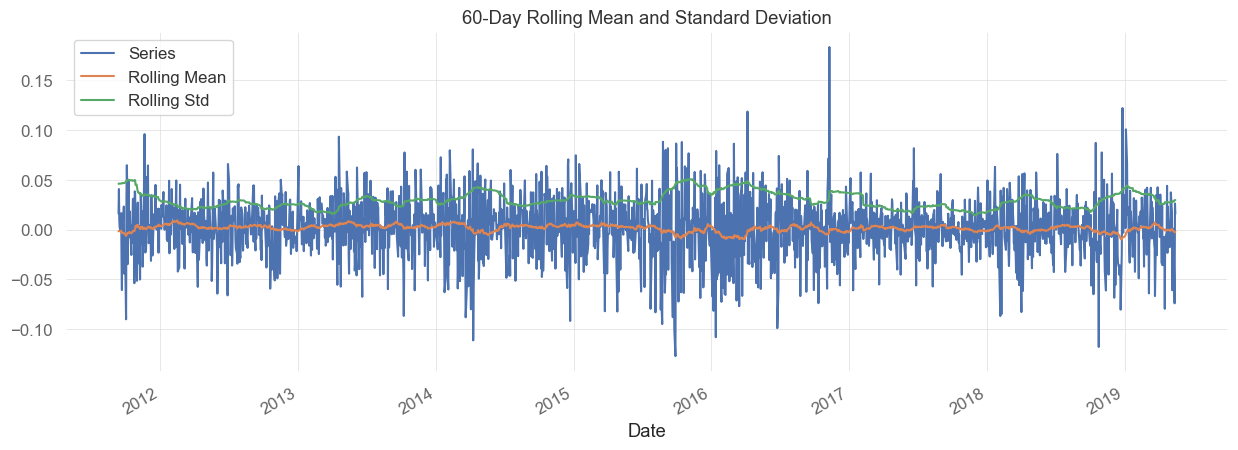

In [5]:
# In this example we can see that though the rolling average is small it is not very
# constant so differencing is a good idea.
series = df_train.iloc[:, 0]
window = 60
plt.figure(figsize=(15, 5))
series[window:].plot()
series_rolling = series.rolling(window=window)
series_rolling.mean()[window:].plot()
series_rolling.std()[window:].plot()
plt.legend(["Series", "Rolling Mean", "Rolling Std"])
plt.title(f"{window}-Day Rolling Mean and Standard Deviation")

Text(0.5, 1.0, '60-Day Rolling Mean and Standard Deviation')

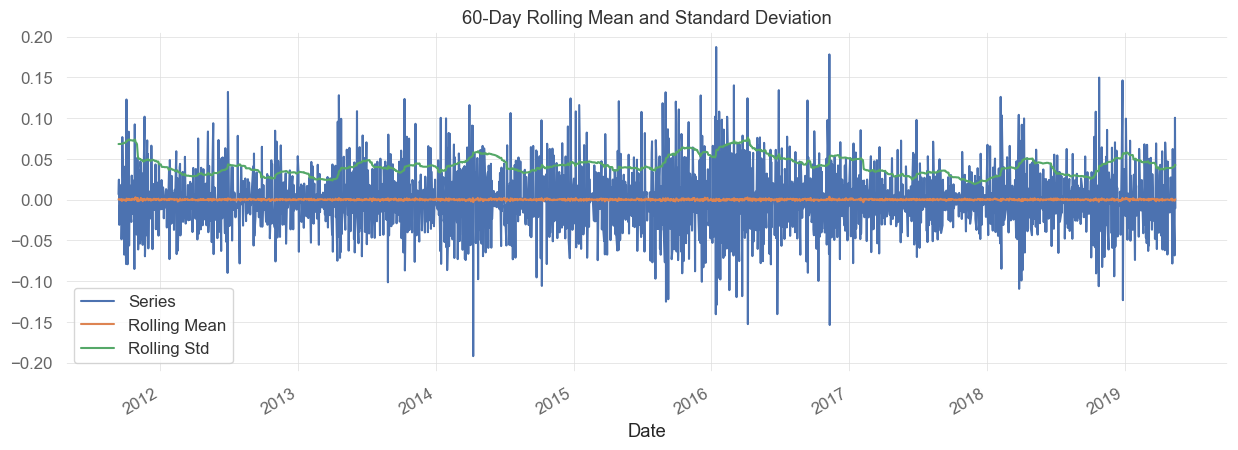

In [6]:
# Applying a first order differencing we see that the rolling average
# is much more constant and close to zero
series = df_train.iloc[:, 0].diff()
window = 60
plt.figure(figsize=(15, 5))
series[window:].plot()
series_rolling = series.rolling(window=window)
series_rolling.mean()[window:].plot()
series_rolling.std()[window:].plot()
plt.legend(["Series", "Rolling Mean", "Rolling Std"])
plt.title(f"{window}-Day Rolling Mean and Standard Deviation")

In [7]:
orders = [
    (2, 1, 0),
    (2, 1, 1),
    (2, 1, 2),
    (5, 1, 0),
    (5, 1, 2),
    (5, 1, 5),
    (10, 1, 0),
    (10, 1, 5),
    (10, 1, 10),
    (0, 1, 2),
    (0, 1, 5),
    (0, 1, 10),
    (20, 1, 0),
    (20, 1, 10),
    (20, 1, 20),
    (0, 1, 20),
]

2024-11-07 10:22:08,796 - stock_logger - INFO - Finished predicting for order (2, 1, 0). Printing summary...


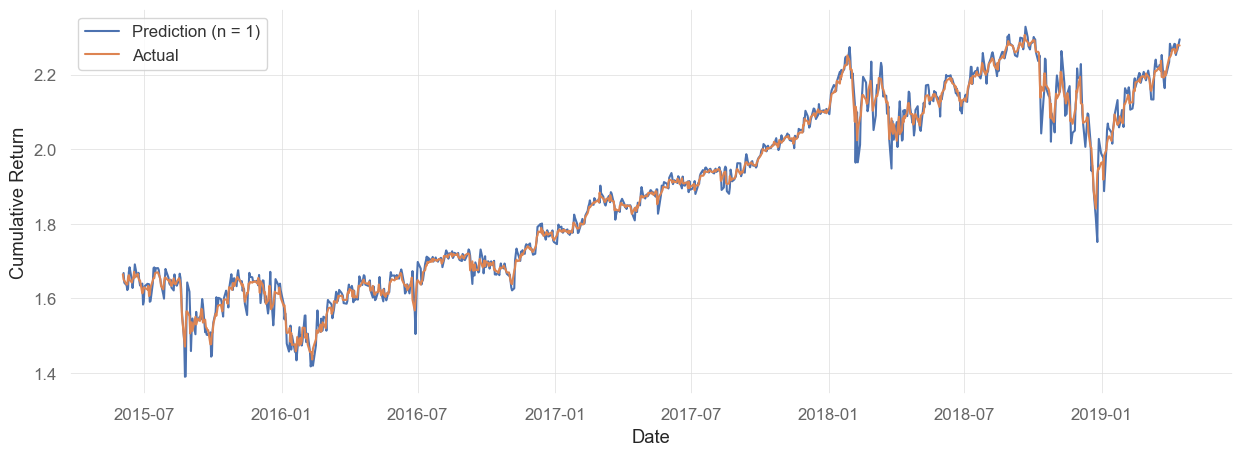

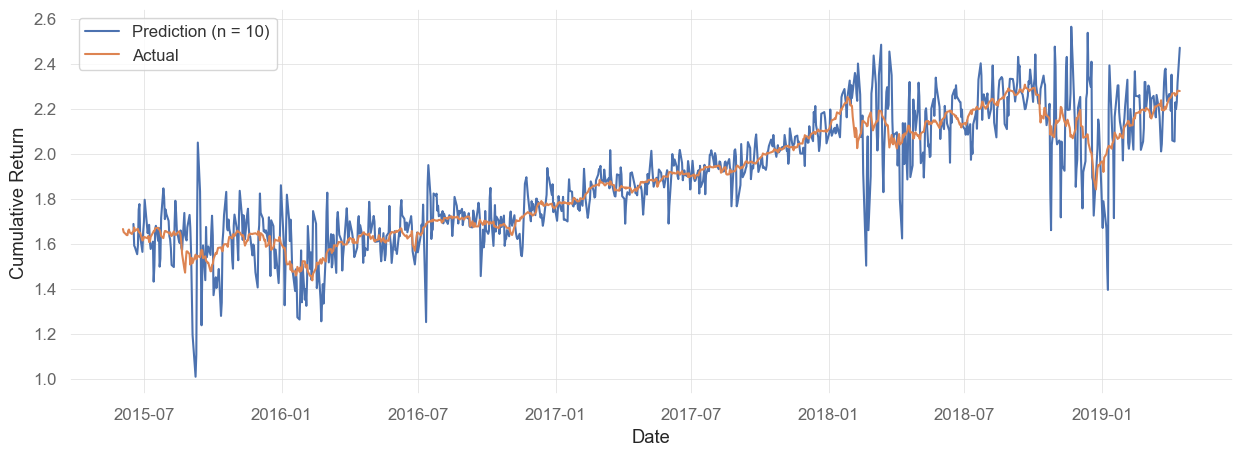

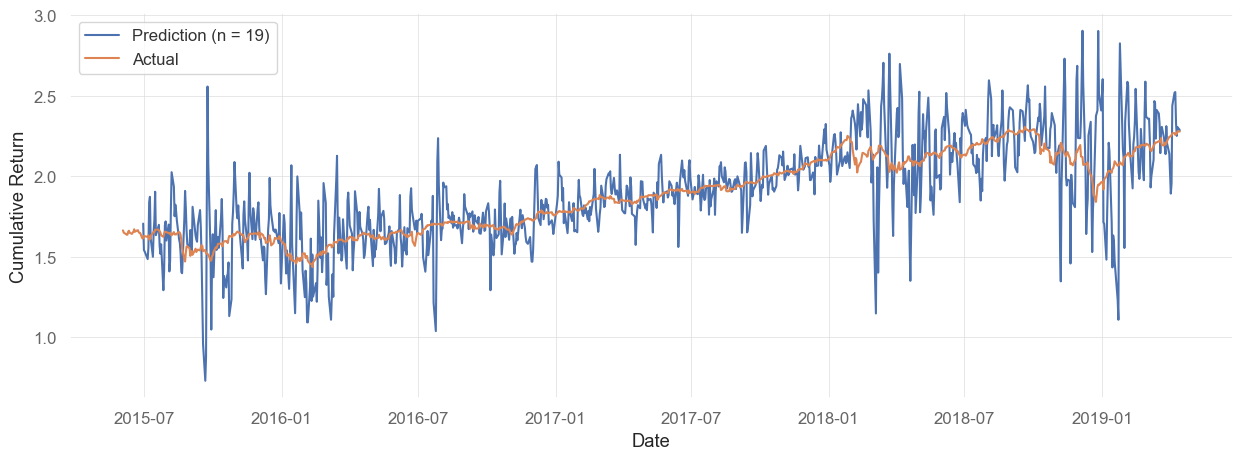

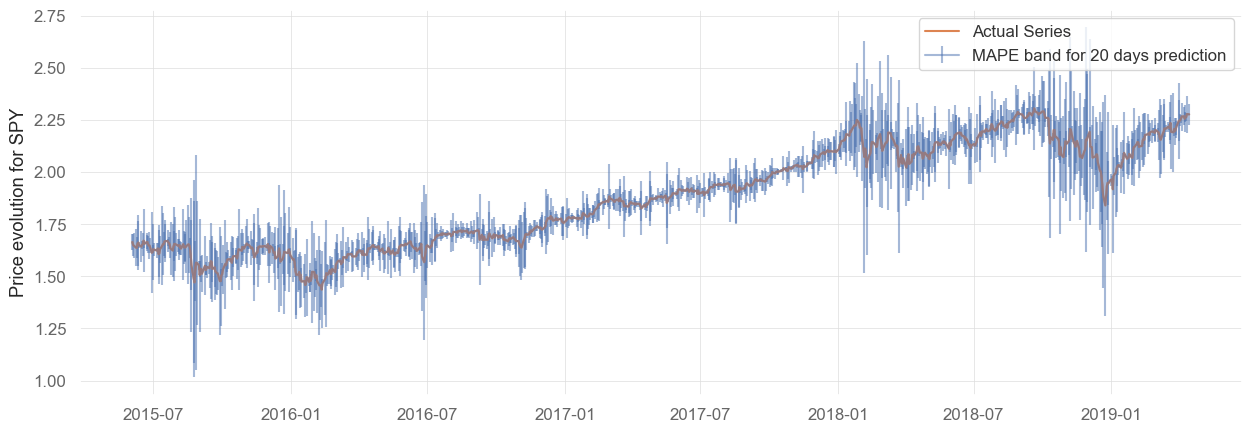

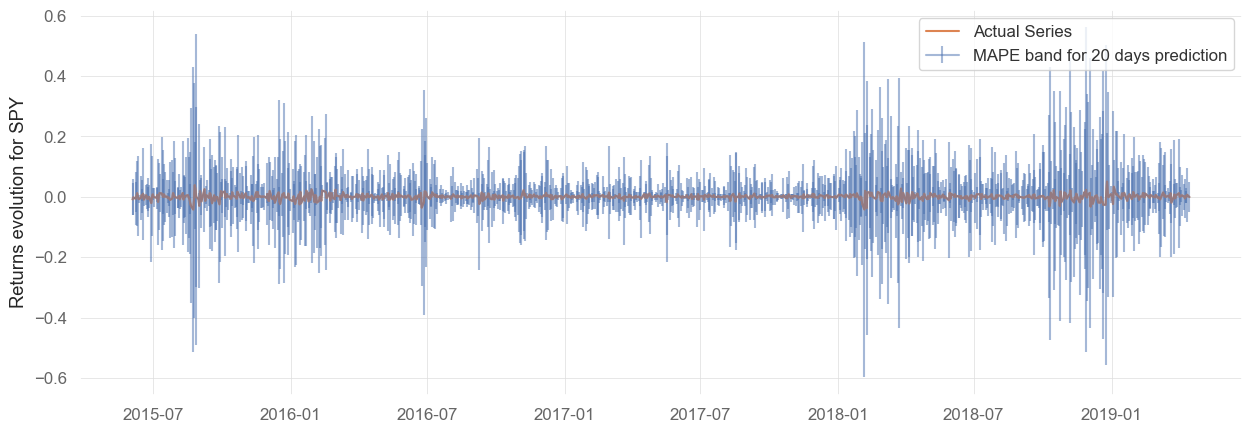

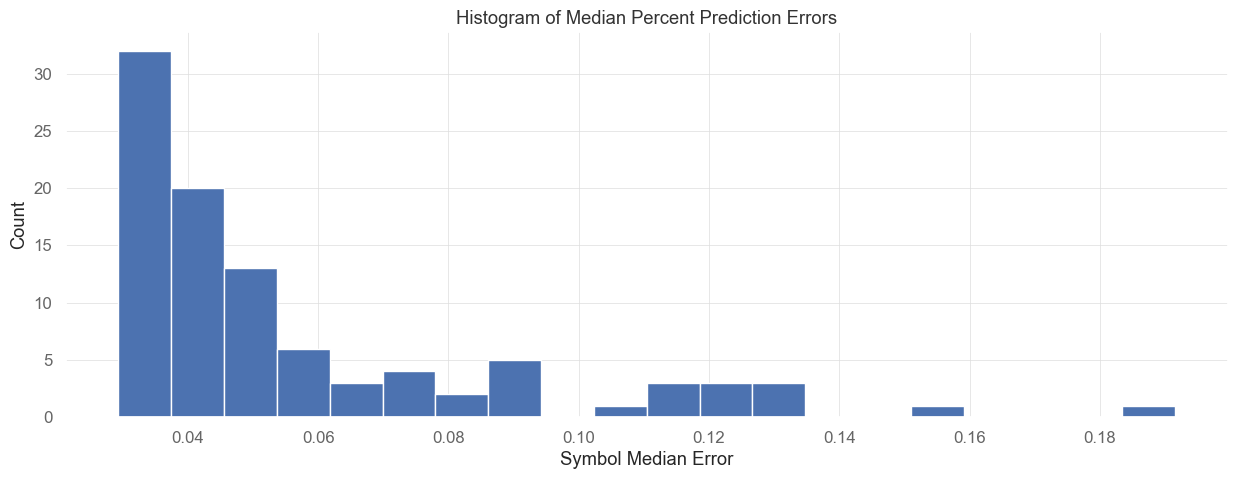

count    97.000000
mean      0.057033
std       0.033024
min       0.029330
25%       0.033166
50%       0.044839
75%       0.064533
max       0.191558
Name: 50%, dtype: float64
Median of Median Errors    0.044839
Mean of Median Errors      0.057033
Mean of Mean Errors        0.076890
dtype: float64


2024-11-07 10:22:12,320 - stock_logger - INFO - Finished predicting for order (2, 1, 1). Printing summary...


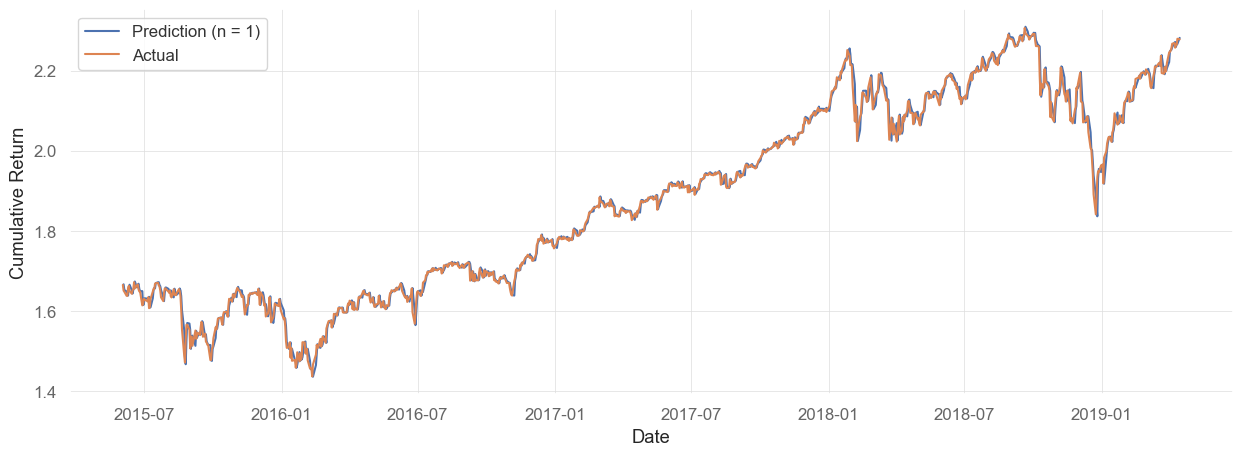

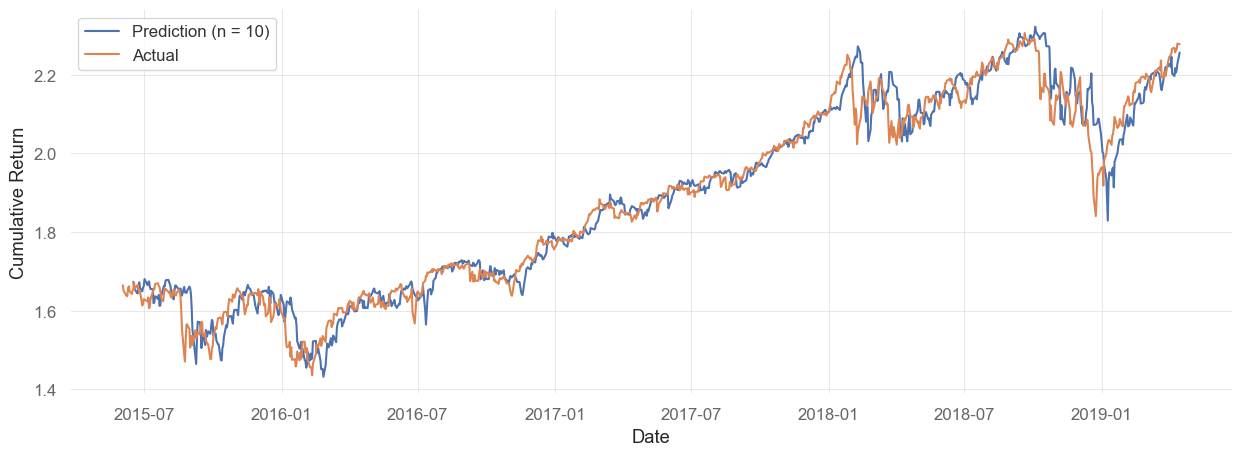

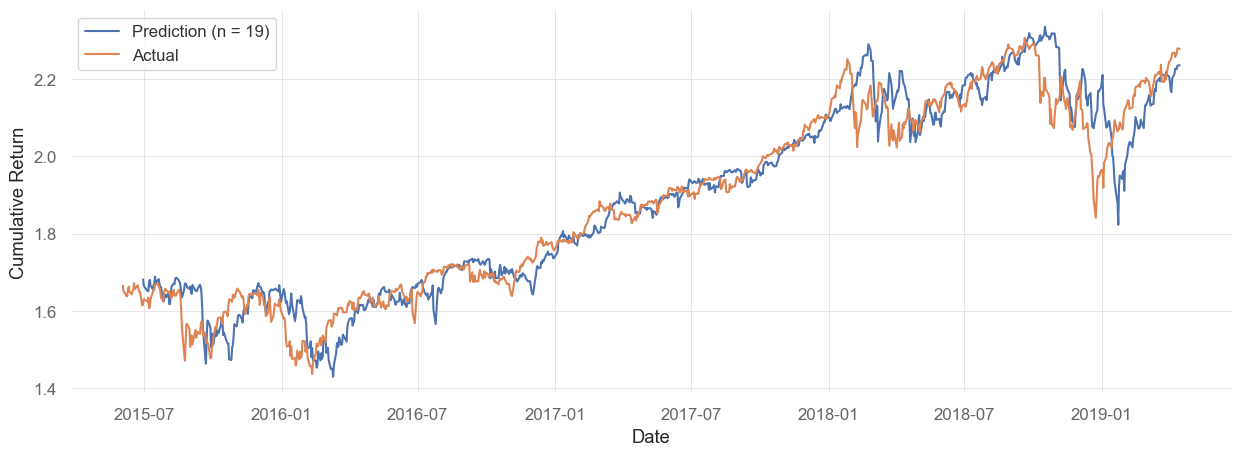

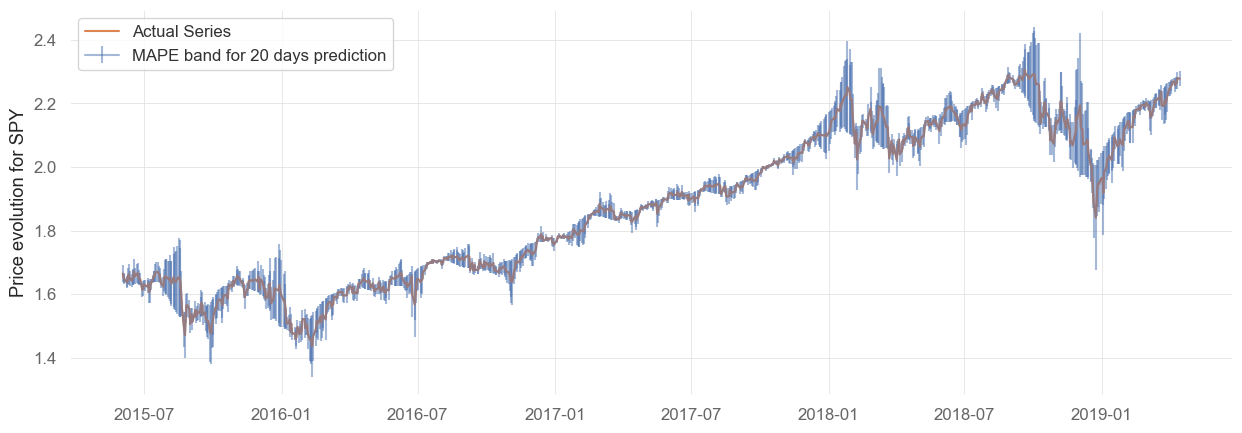

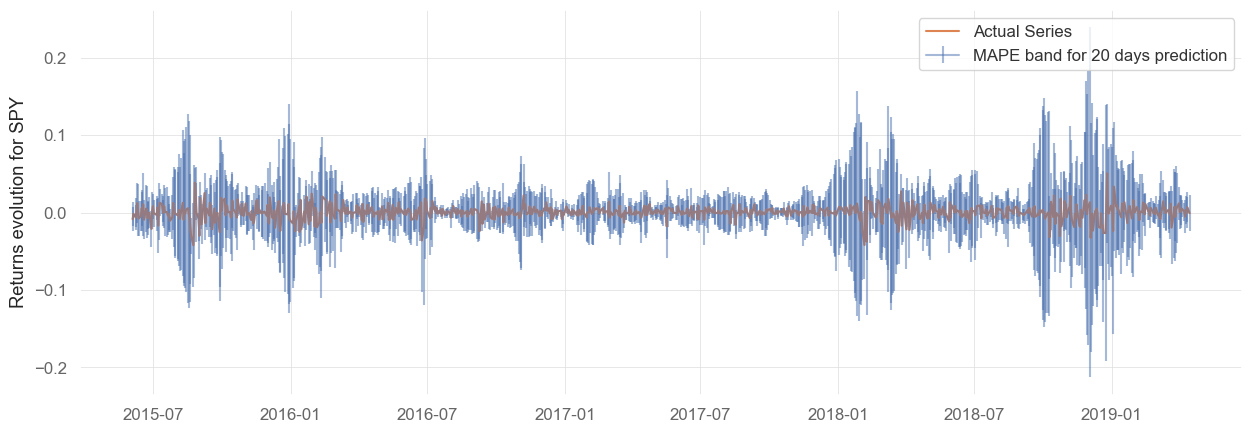

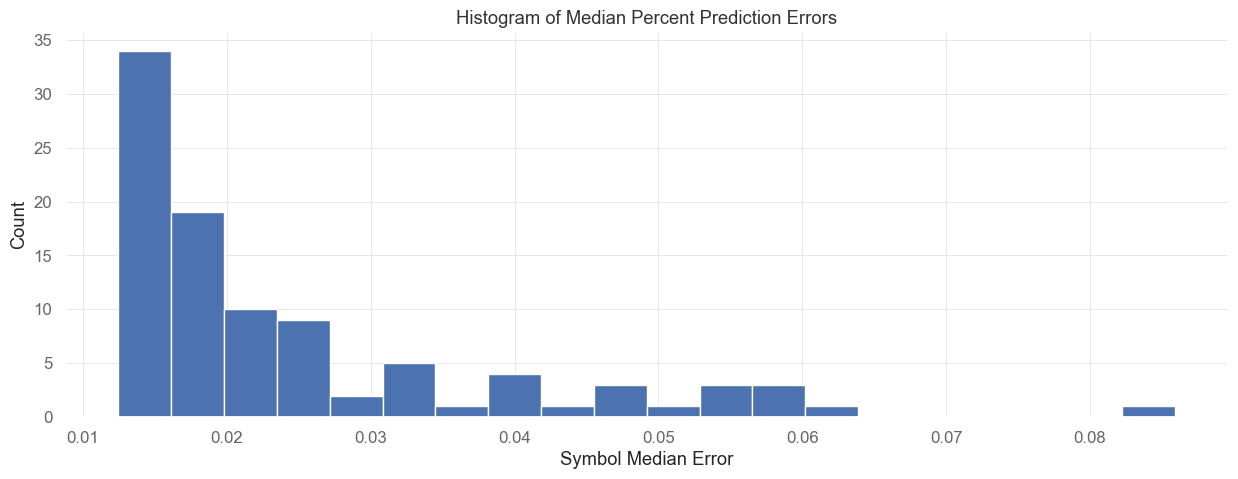

count    97.000000
mean      0.024795
std       0.014432
min       0.012453
25%       0.014520
50%       0.019491
75%       0.028195
max       0.085917
Name: 50%, dtype: float64
Median of Median Errors    0.019491
Mean of Median Errors      0.024795
Mean of Mean Errors        0.032083
dtype: float64


2024-11-07 10:22:15,694 - stock_logger - INFO - Finished predicting for order (2, 1, 2). Printing summary...


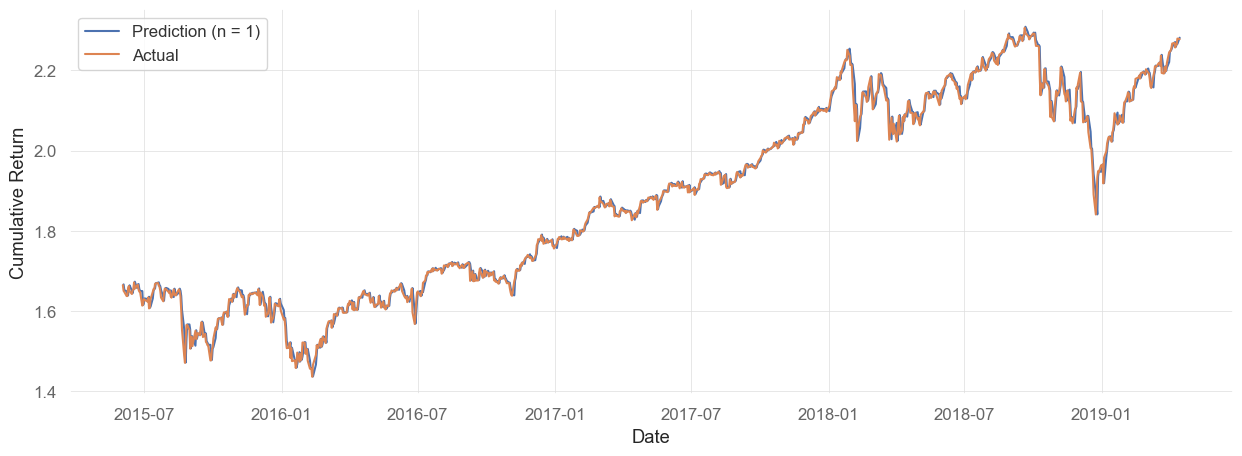

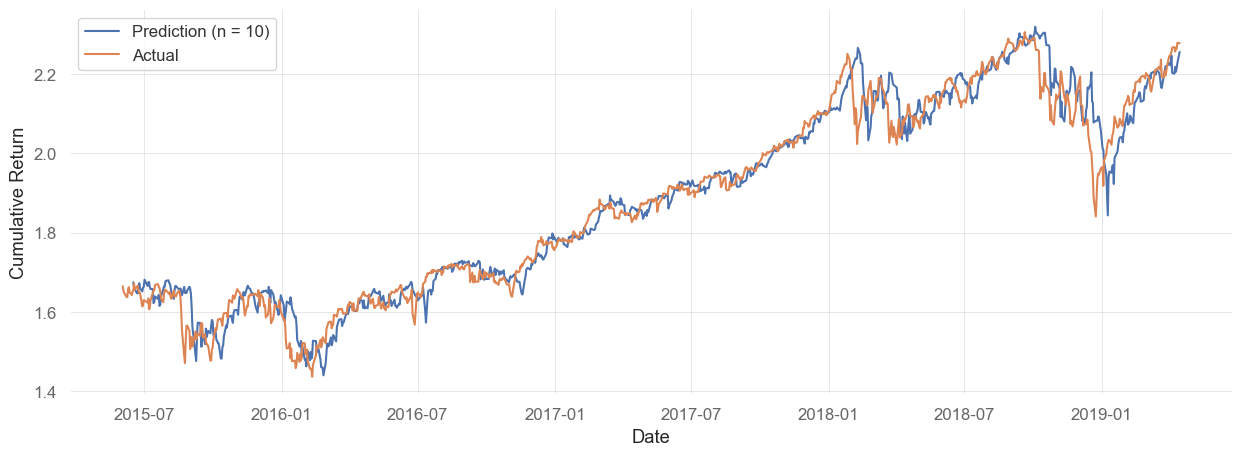

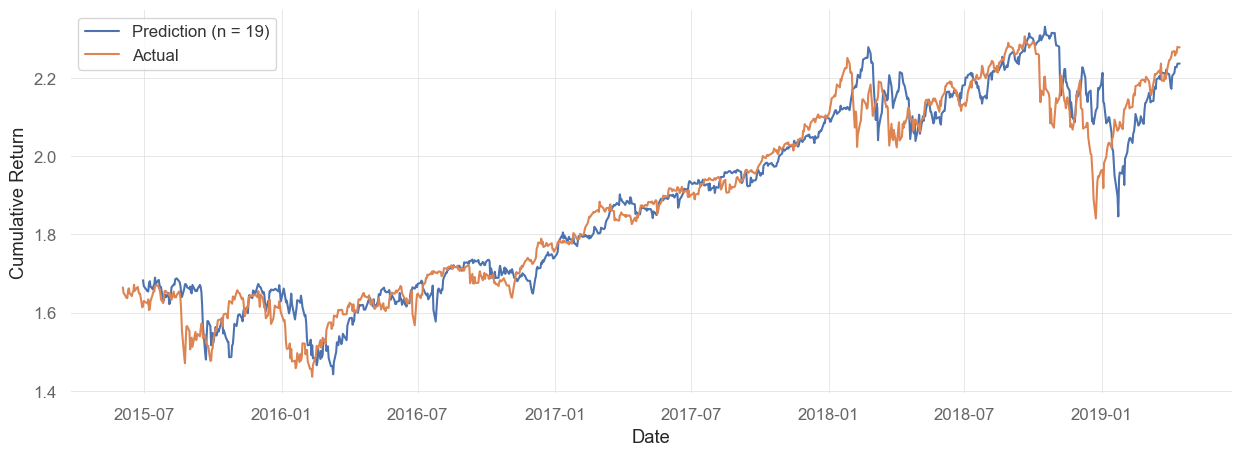

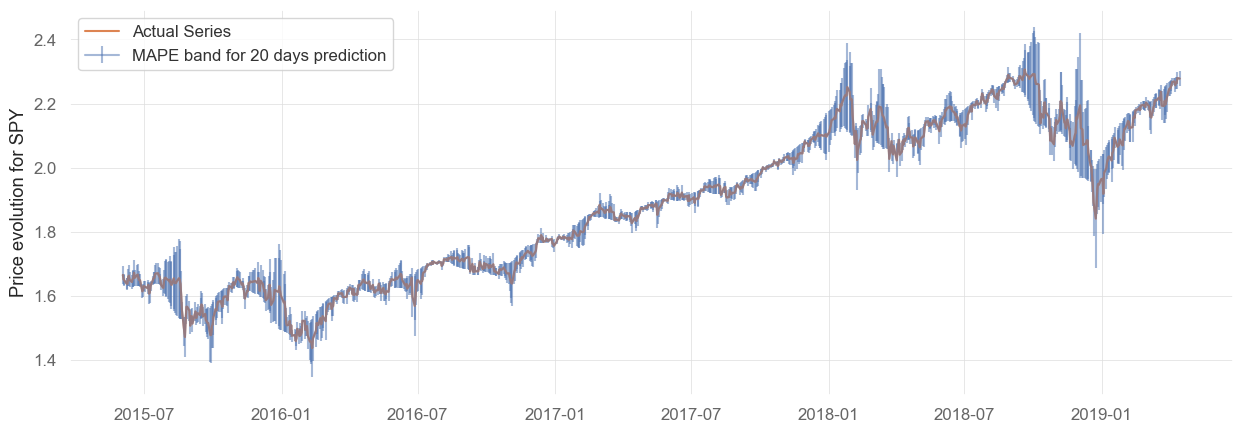

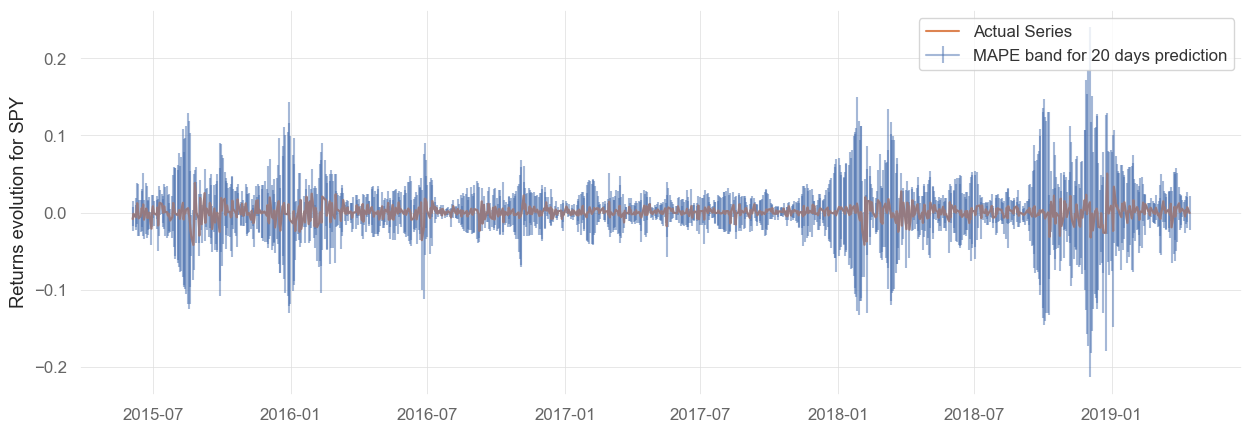

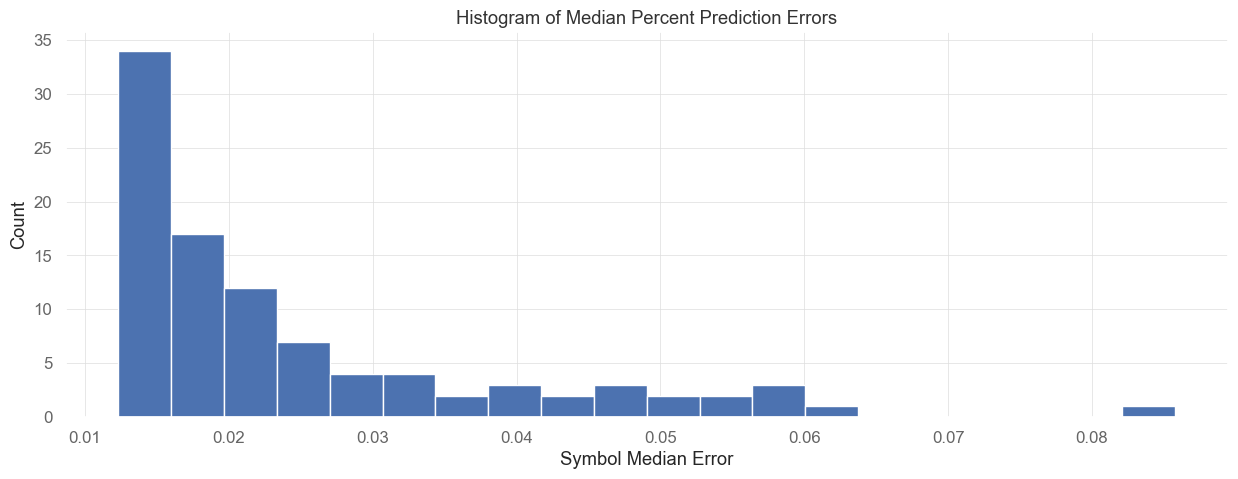

count    97.000000
mean      0.024674
std       0.014385
min       0.012315
25%       0.014709
50%       0.019283
75%       0.028197
max       0.085778
Name: 50%, dtype: float64
Median of Median Errors    0.019283
Mean of Median Errors      0.024674
Mean of Mean Errors        0.031873
dtype: float64


2024-11-07 10:22:19,340 - stock_logger - INFO - Finished predicting for order (5, 1, 0). Printing summary...


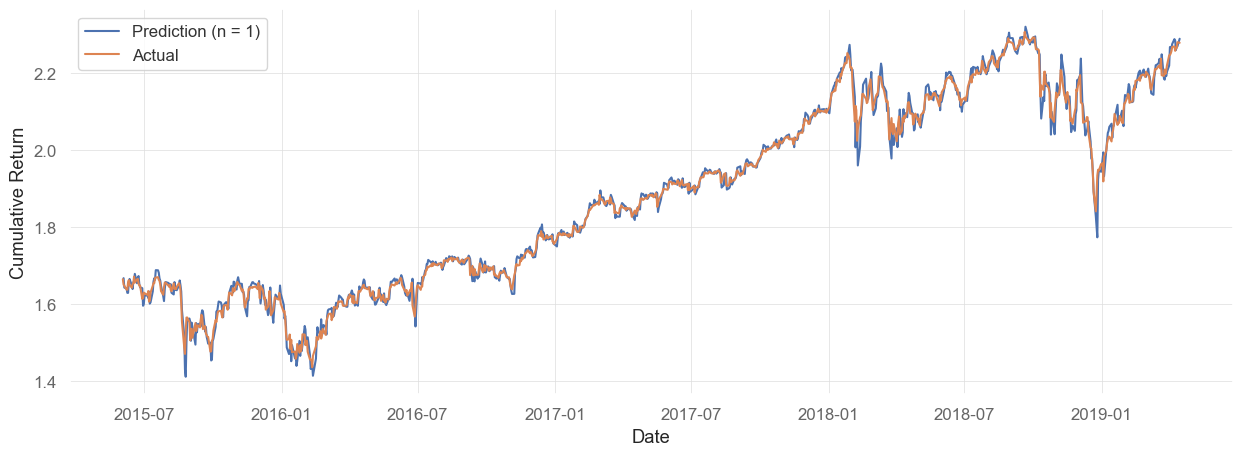

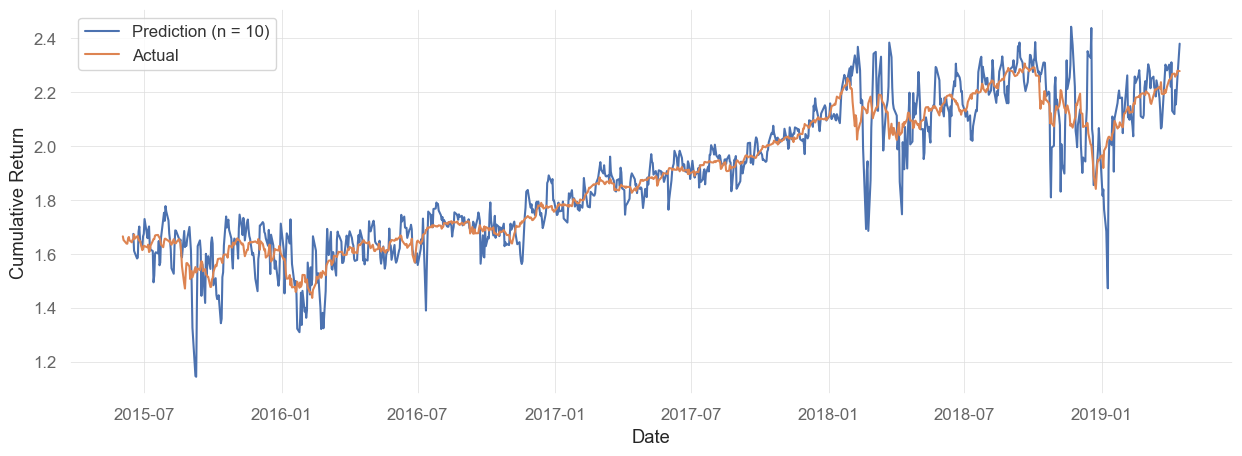

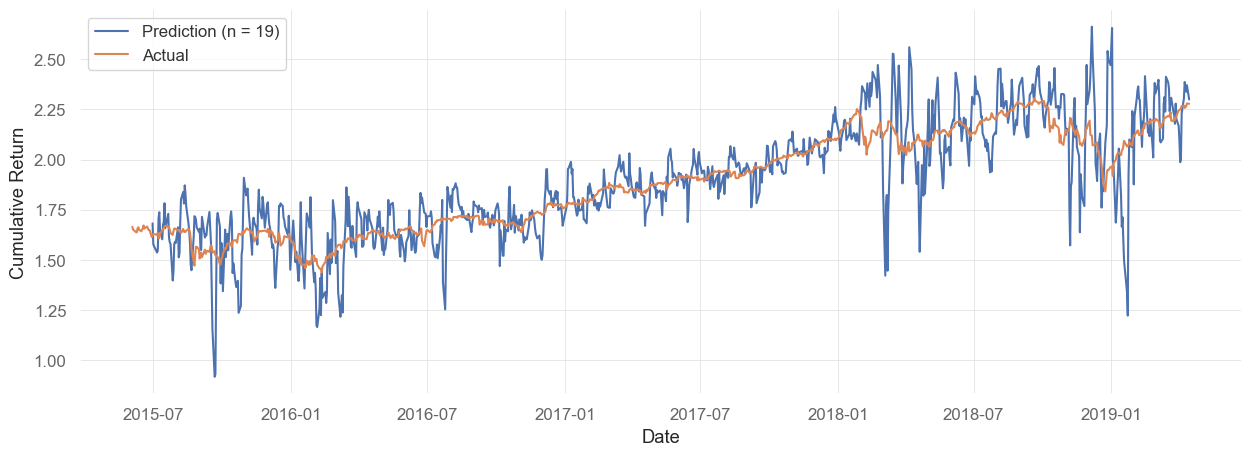

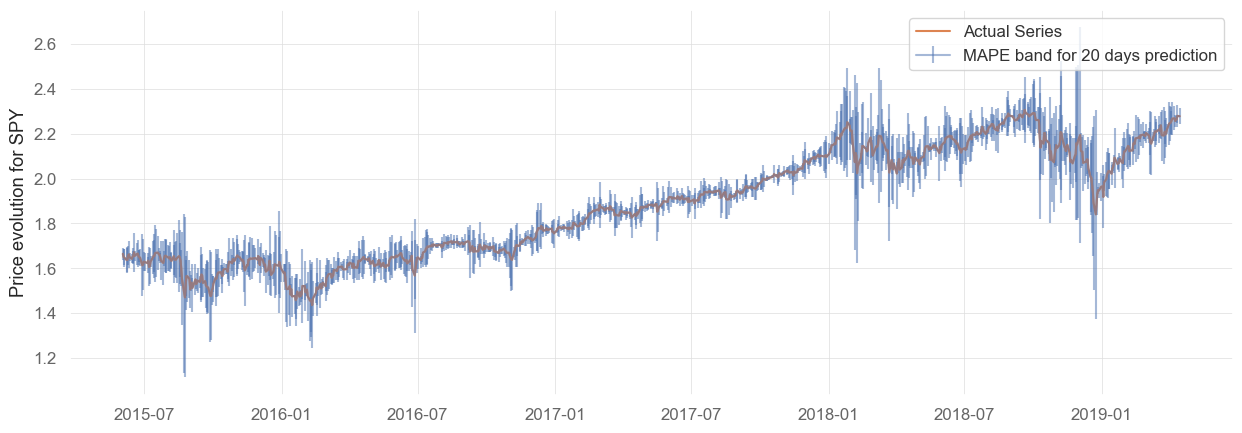

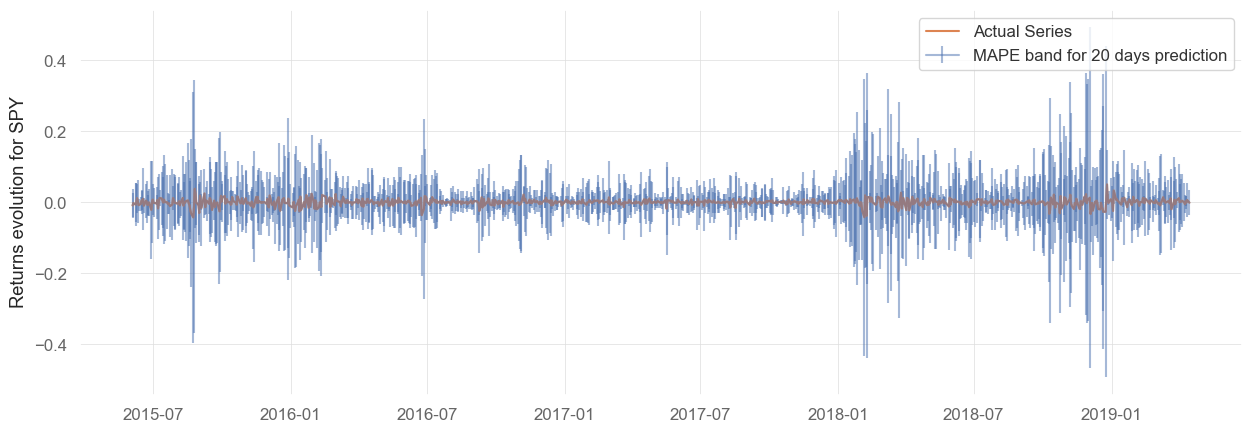

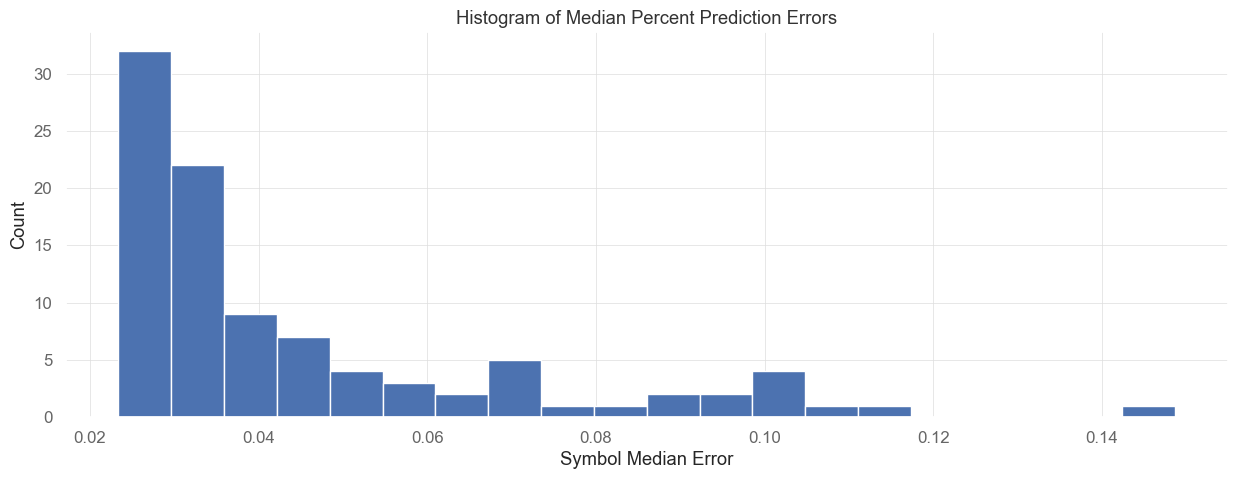

2024-11-07 10:22:22,733 - stock_logger - INFO - Finished predicting for order (5, 1, 2). Printing summary...


count    97.000000
mean      0.045116
std       0.025601
min       0.023363
25%       0.027258
50%       0.035165
75%       0.051410
max       0.148692
Name: 50%, dtype: float64
Median of Median Errors    0.035165
Mean of Median Errors      0.045116
Mean of Mean Errors        0.058847
dtype: float64


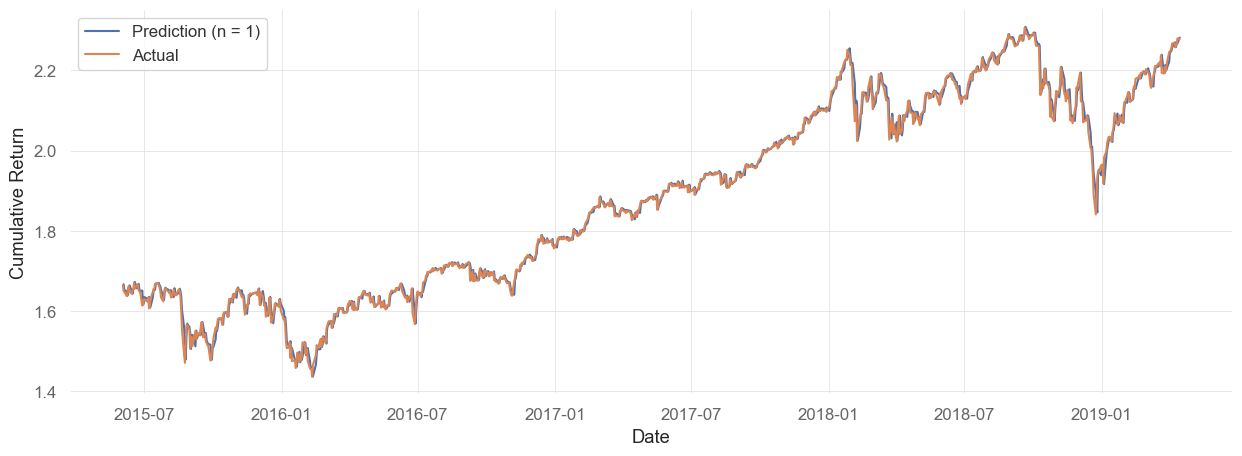

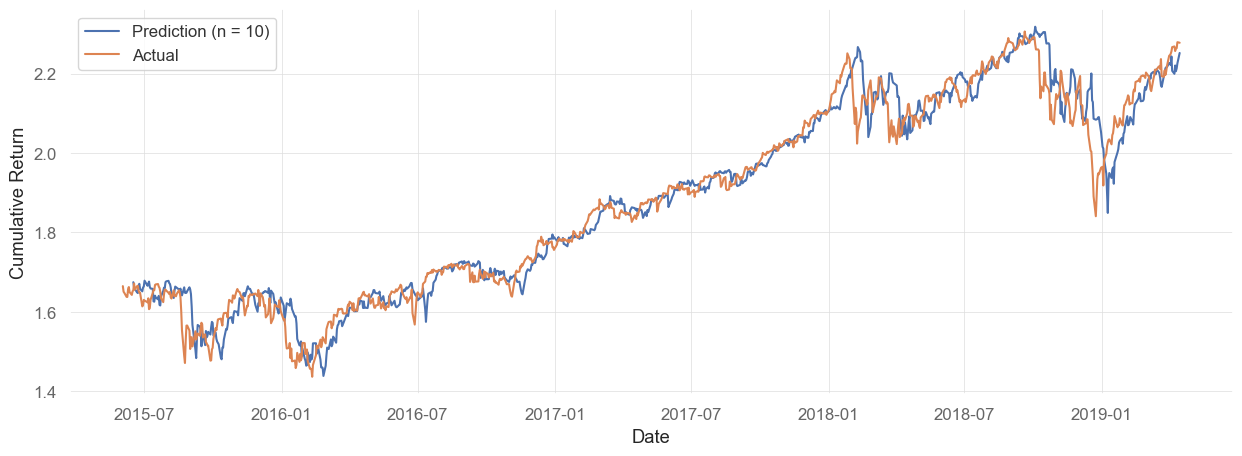

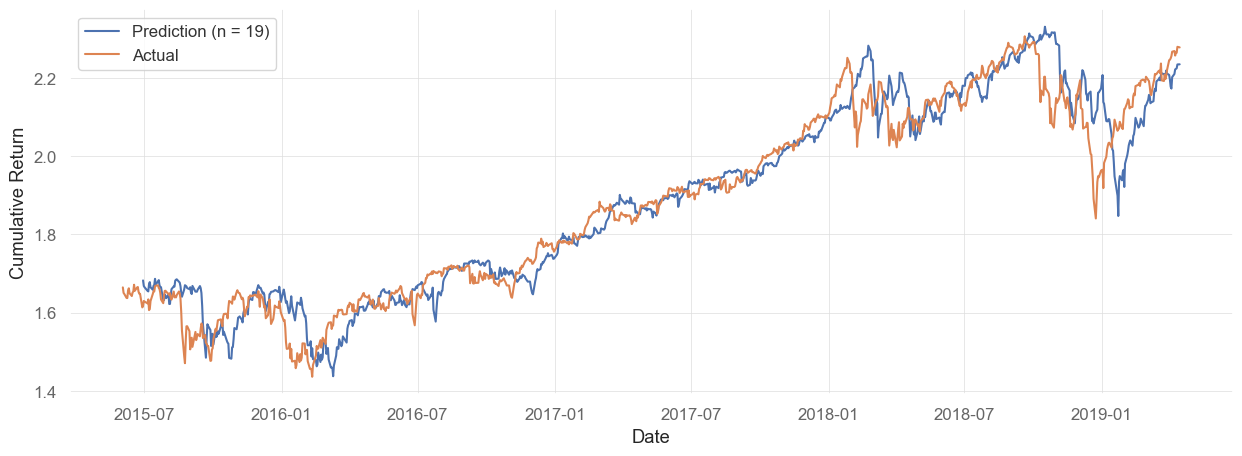

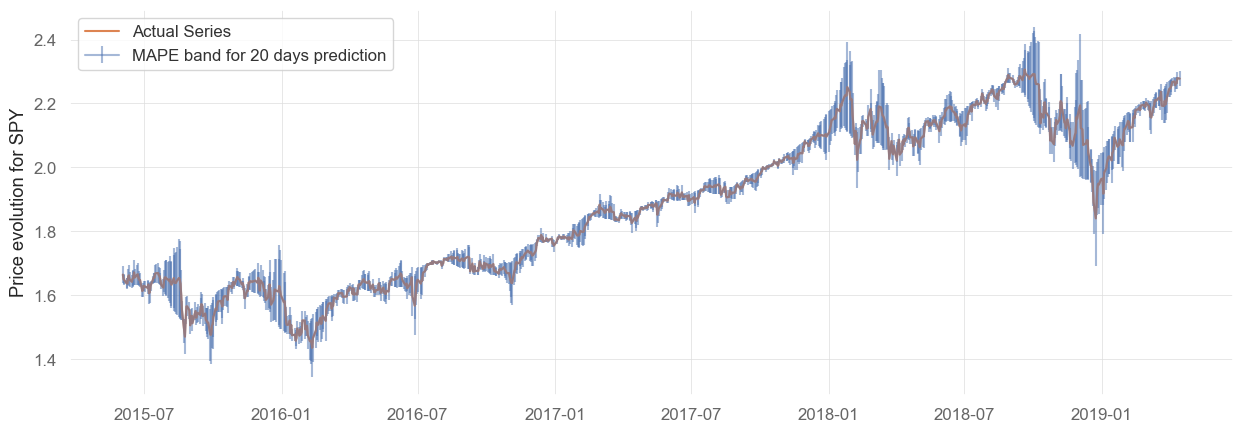

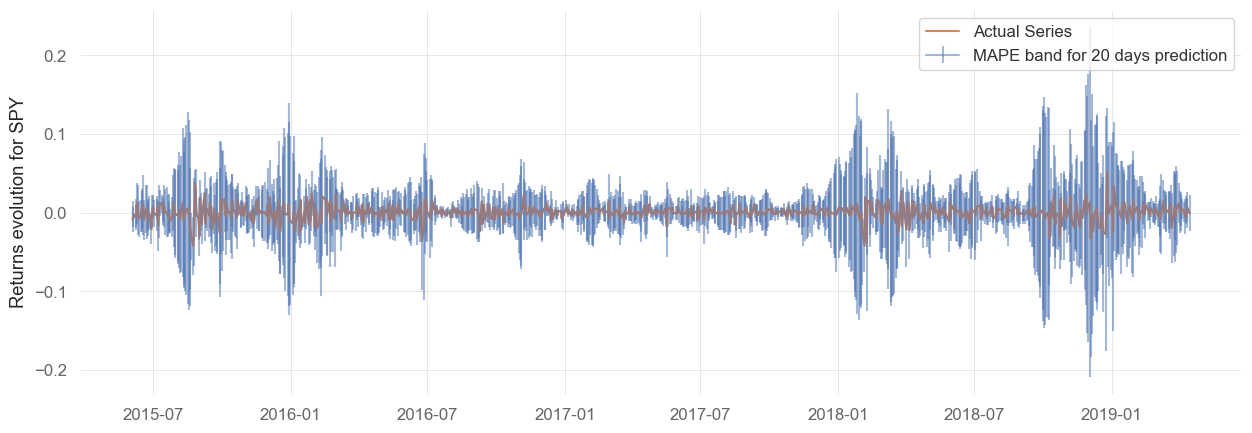

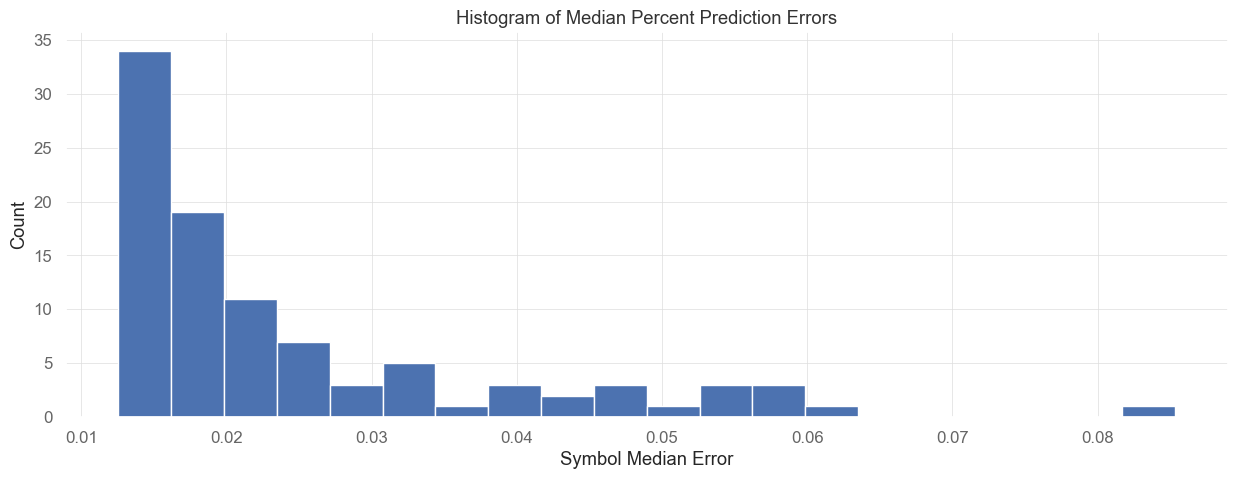

count    97.000000
mean      0.024704
std       0.014344
min       0.012555
25%       0.014427
50%       0.019370
75%       0.028410
max       0.085344
Name: 50%, dtype: float64
Median of Median Errors    0.019370
Mean of Median Errors      0.024704
Mean of Mean Errors        0.031980
dtype: float64


2024-11-07 10:22:25,892 - stock_logger - INFO - Finished predicting for order (5, 1, 5). Printing summary...


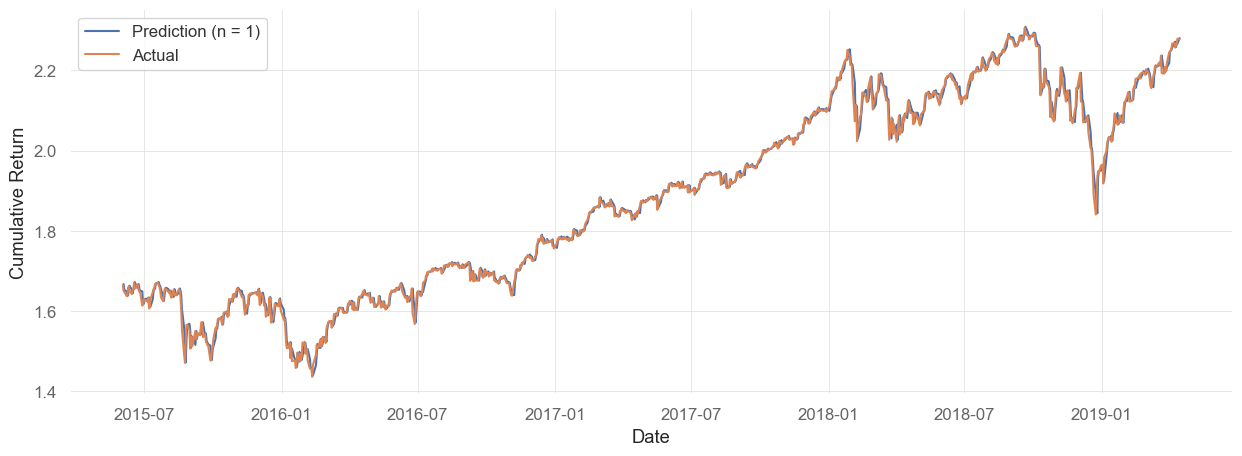

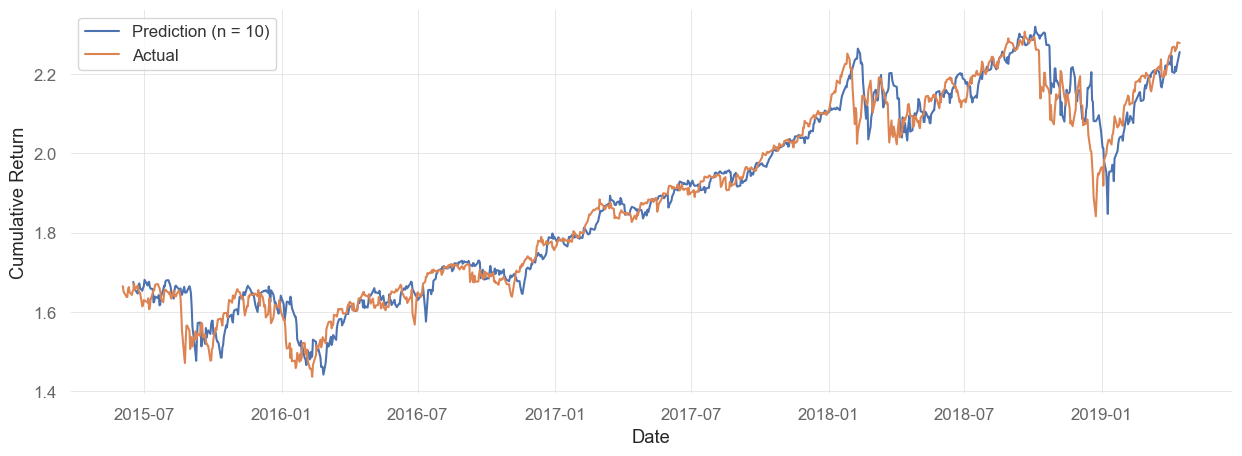

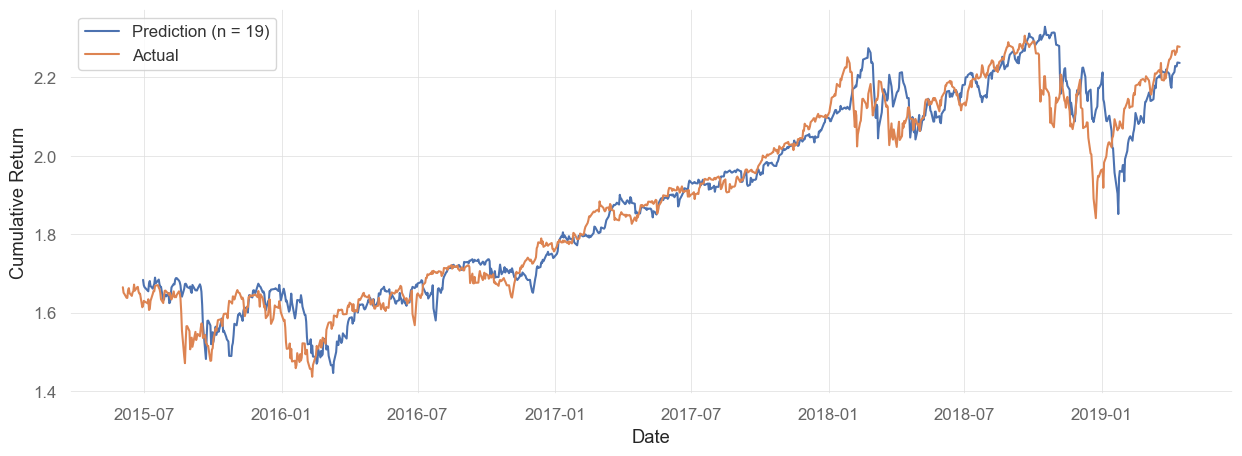

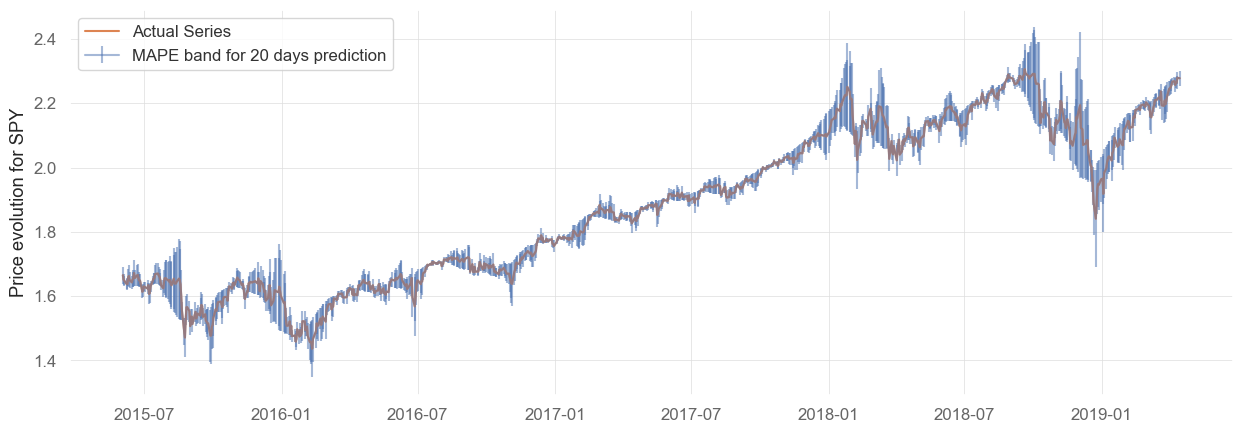

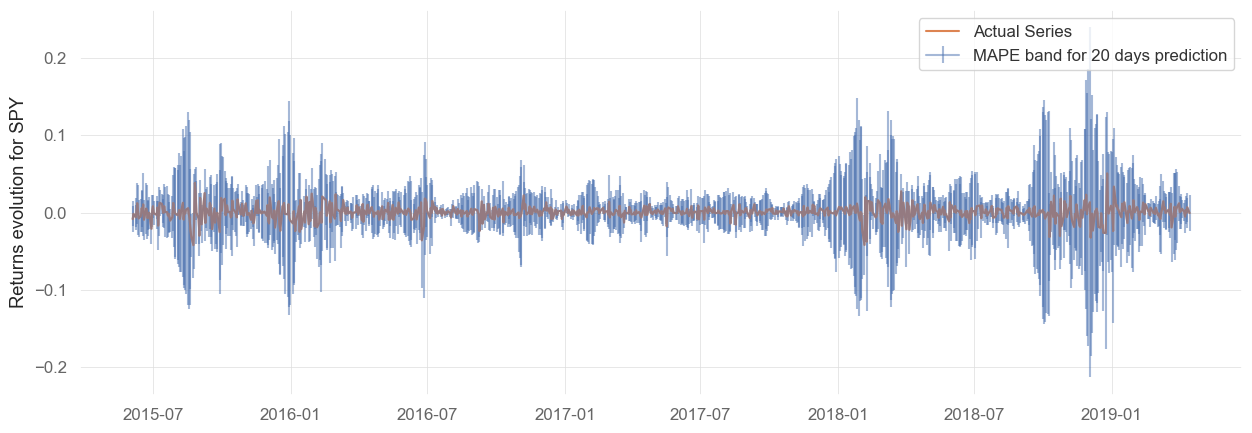

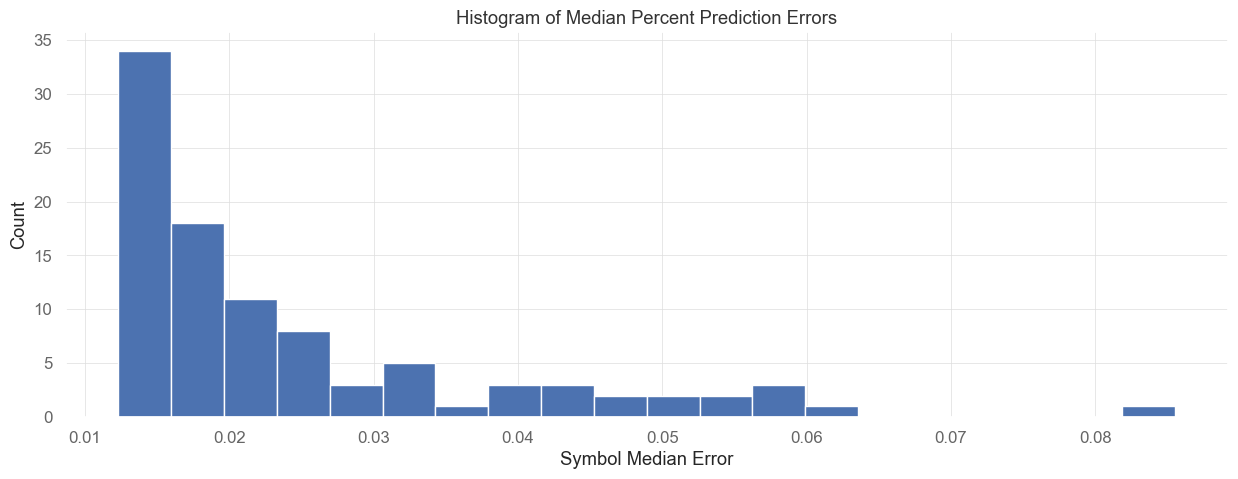

count    97.000000
mean      0.024620
std       0.014354
min       0.012324
25%       0.014580
50%       0.019259
75%       0.028451
max       0.085525
Name: 50%, dtype: float64
Median of Median Errors    0.019259
Mean of Median Errors      0.024620
Mean of Mean Errors        0.031806
dtype: float64


2024-11-07 10:22:29,340 - stock_logger - INFO - Finished predicting for order (10, 1, 0). Printing summary...


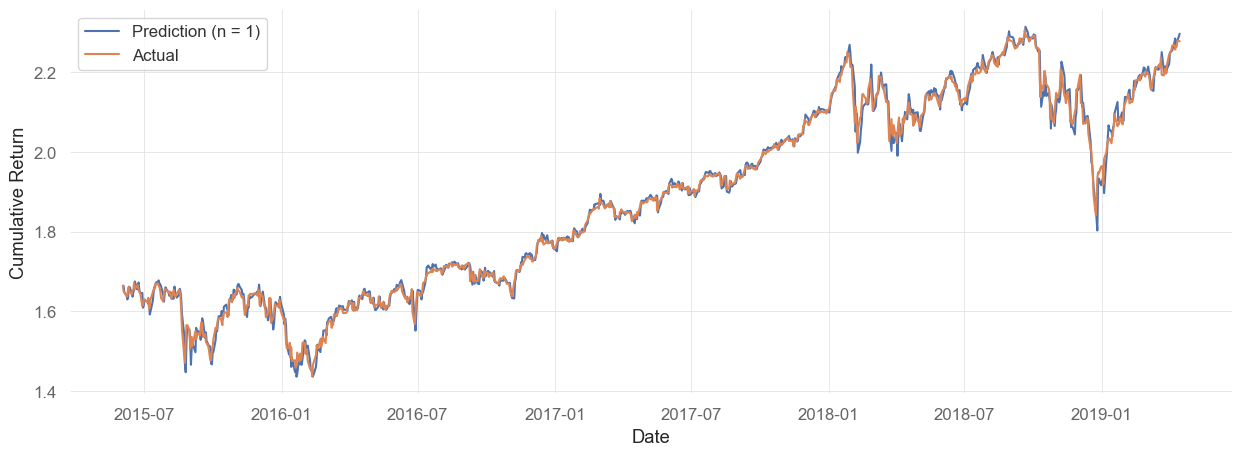

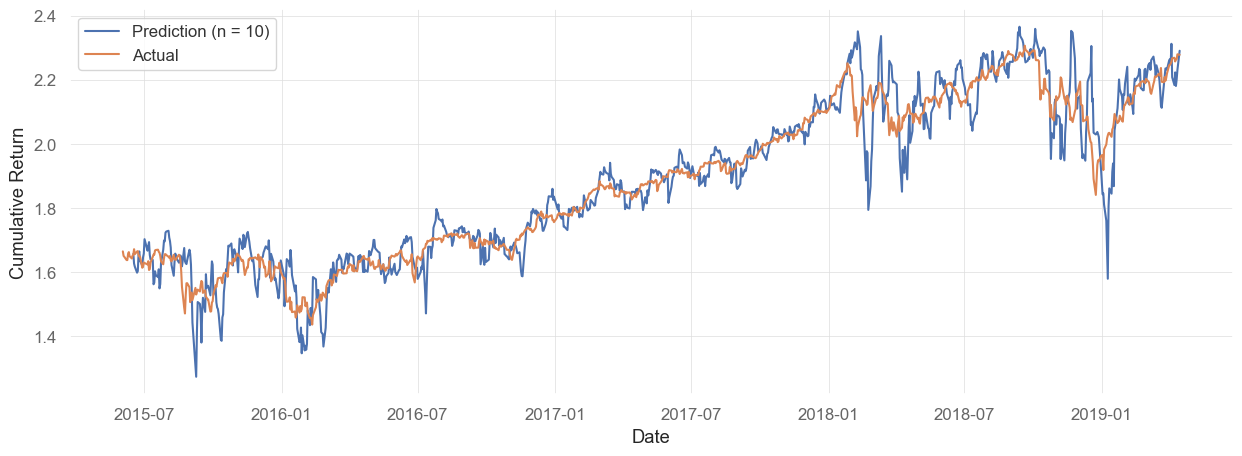

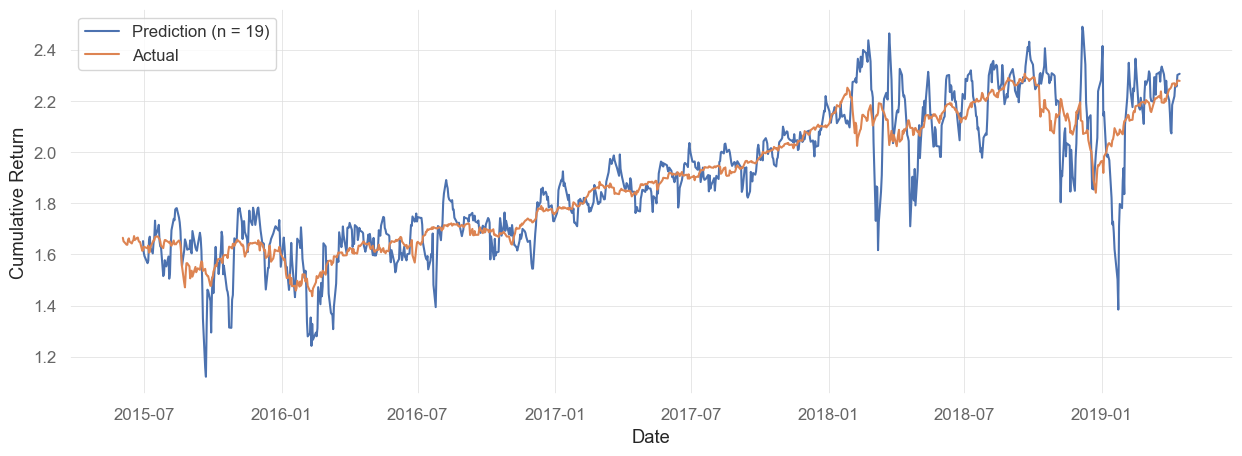

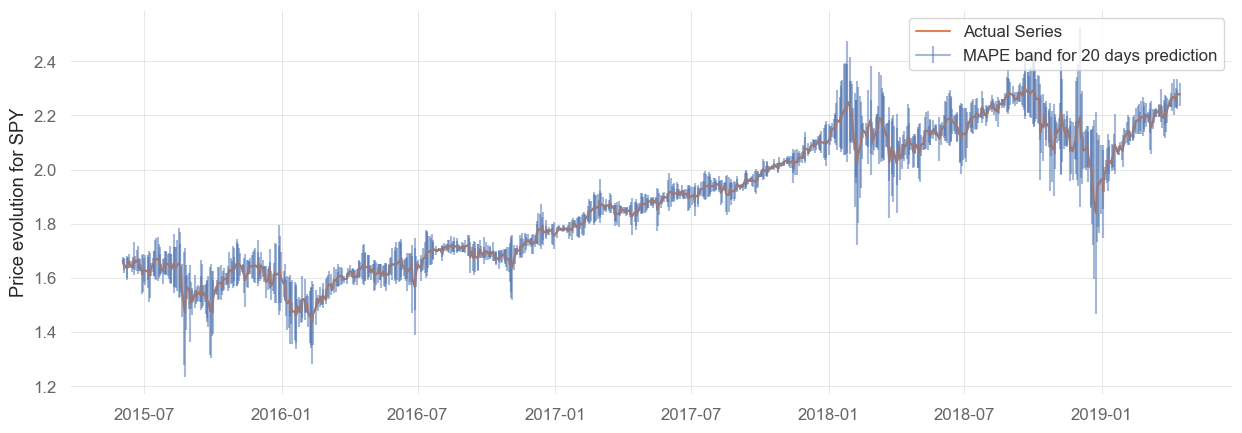

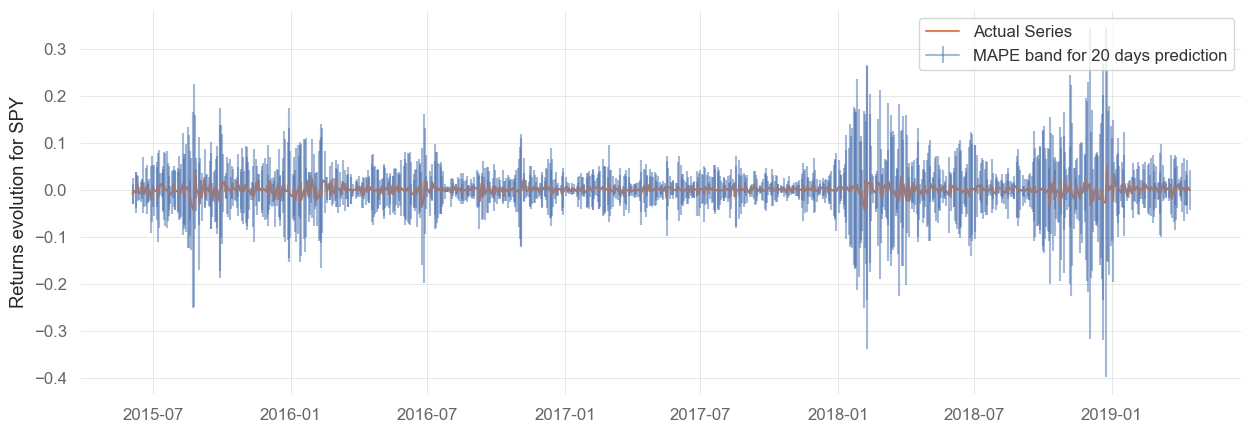

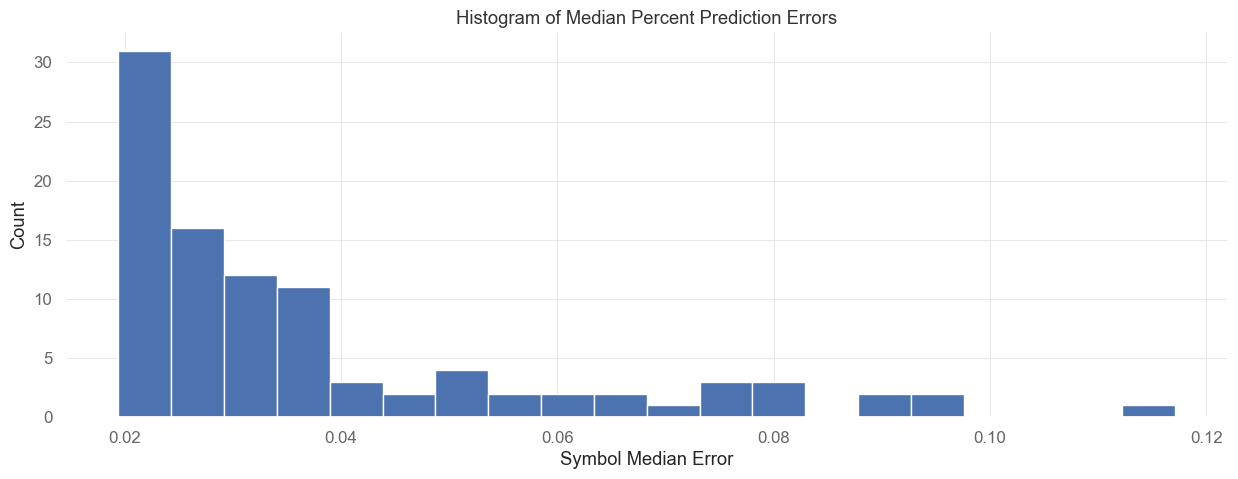

count    97.000000
mean      0.037755
std       0.021659
min       0.019404
25%       0.021691
50%       0.029624
75%       0.043542
max       0.117132
Name: 50%, dtype: float64
Median of Median Errors    0.029624
Mean of Median Errors      0.037755
Mean of Mean Errors        0.048395
dtype: float64


2024-11-07 10:22:32,876 - stock_logger - INFO - Finished predicting for order (10, 1, 5). Printing summary...


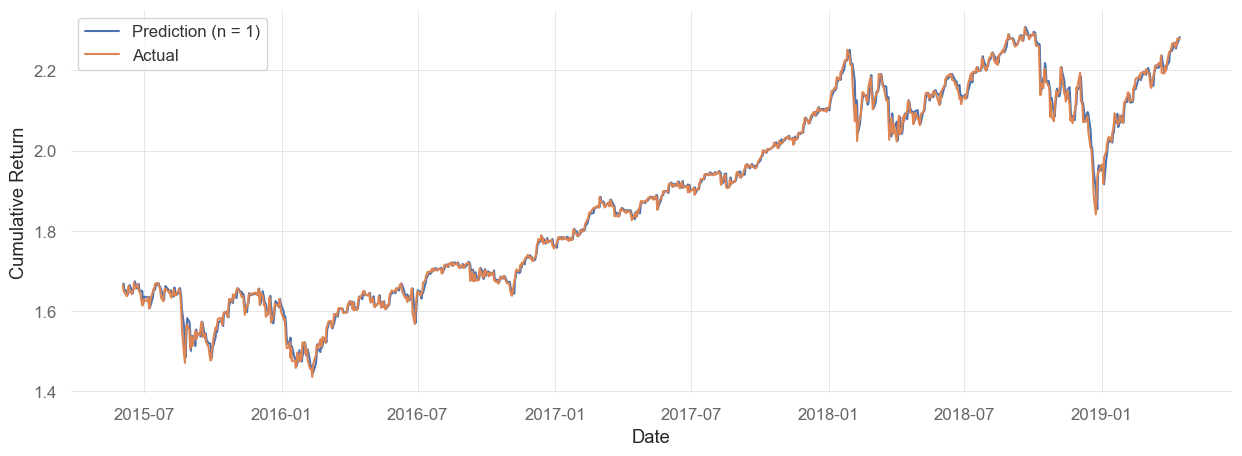

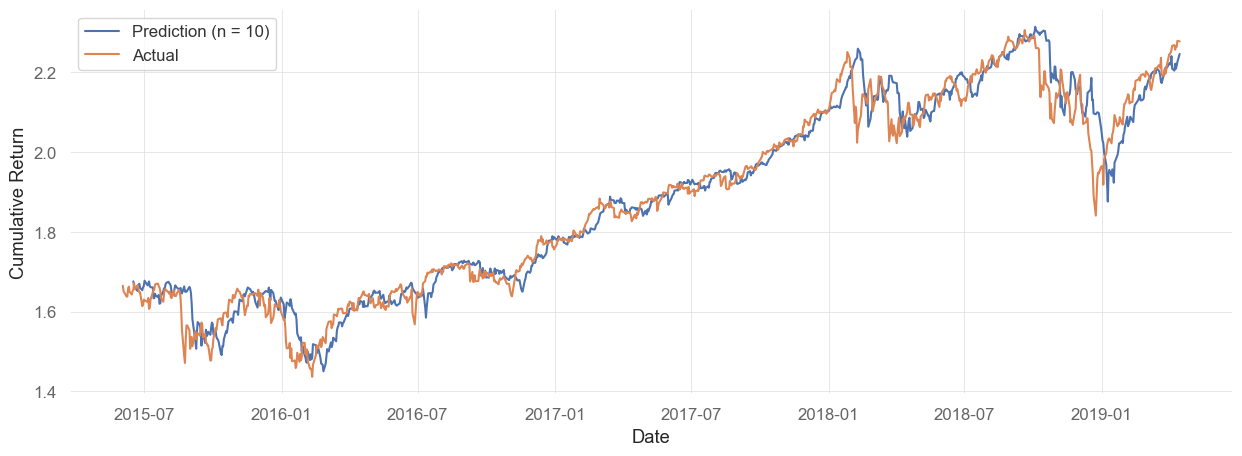

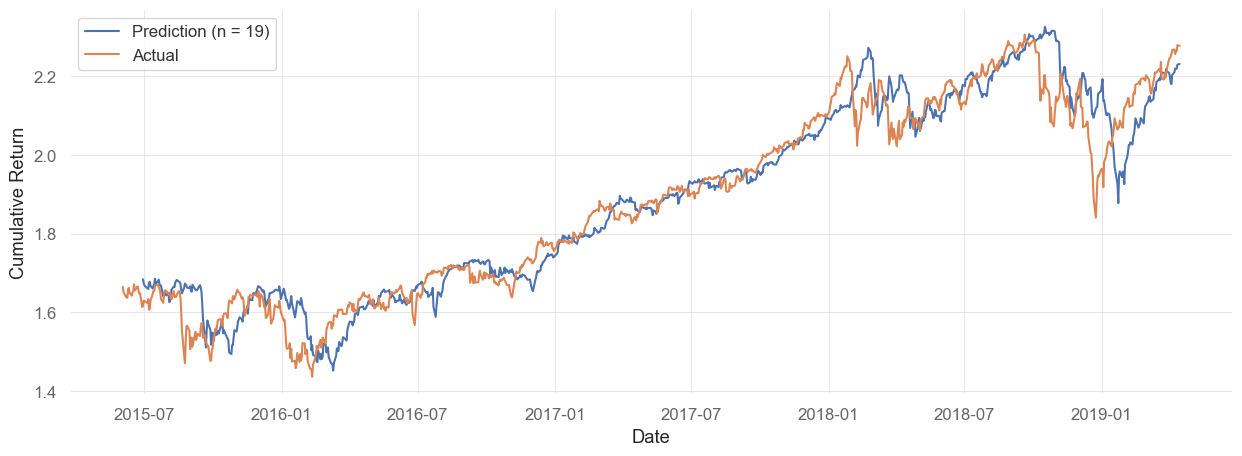

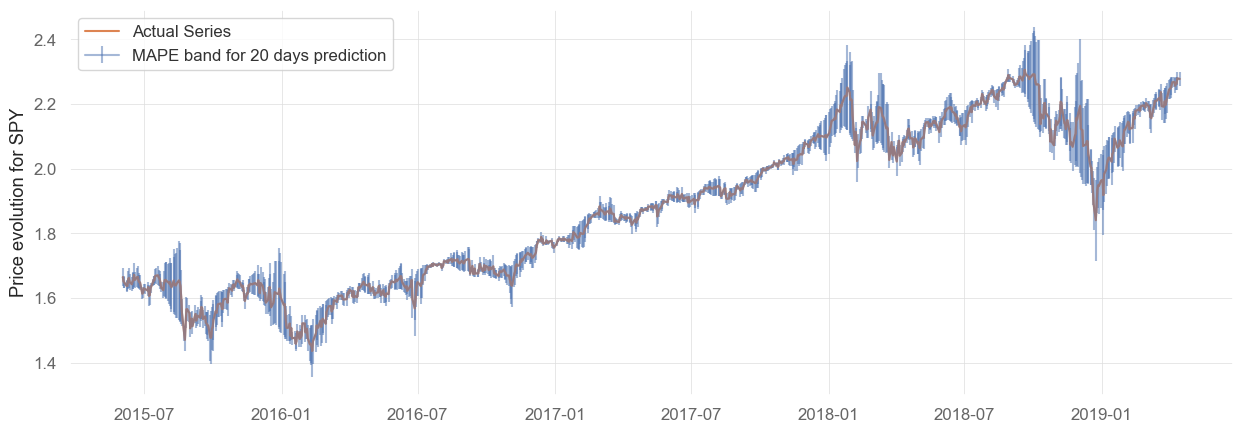

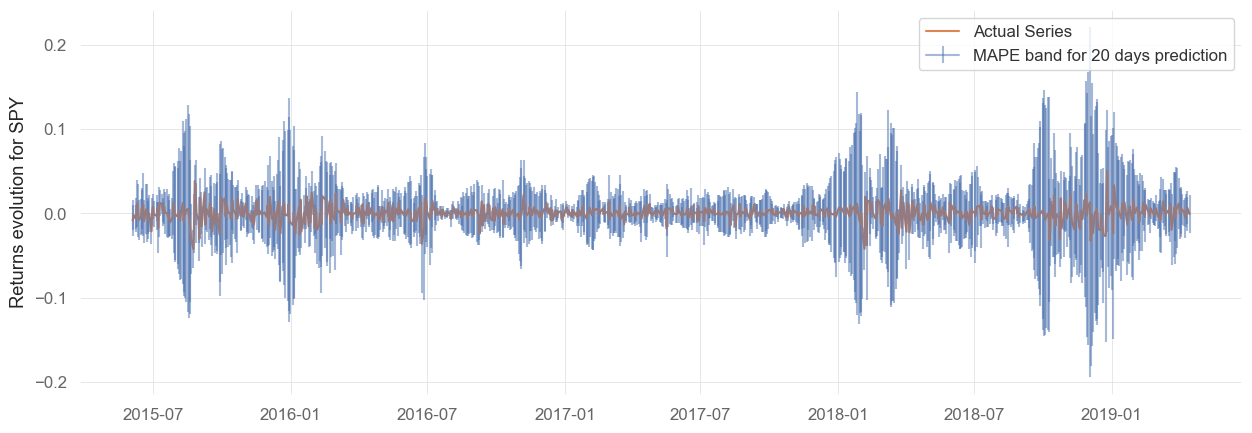

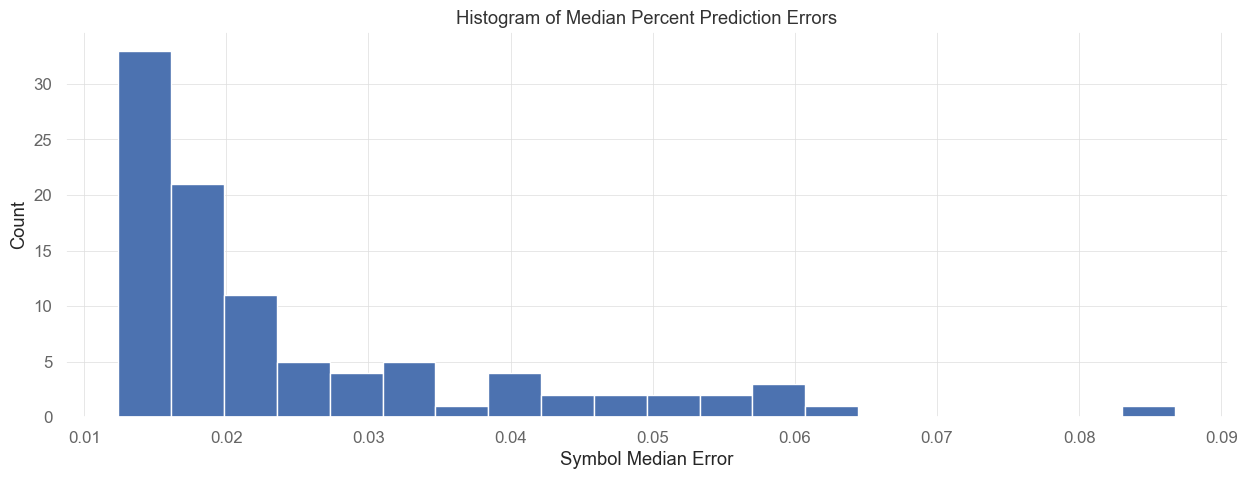

count    97.000000
mean      0.024697
std       0.014440
min       0.012407
25%       0.014367
50%       0.019306
75%       0.027942
max       0.086756
Name: 50%, dtype: float64
Median of Median Errors    0.019306
Mean of Median Errors      0.024697
Mean of Mean Errors        0.032020
dtype: float64


2024-11-07 10:22:36,078 - stock_logger - INFO - Finished predicting for order (10, 1, 10). Printing summary...


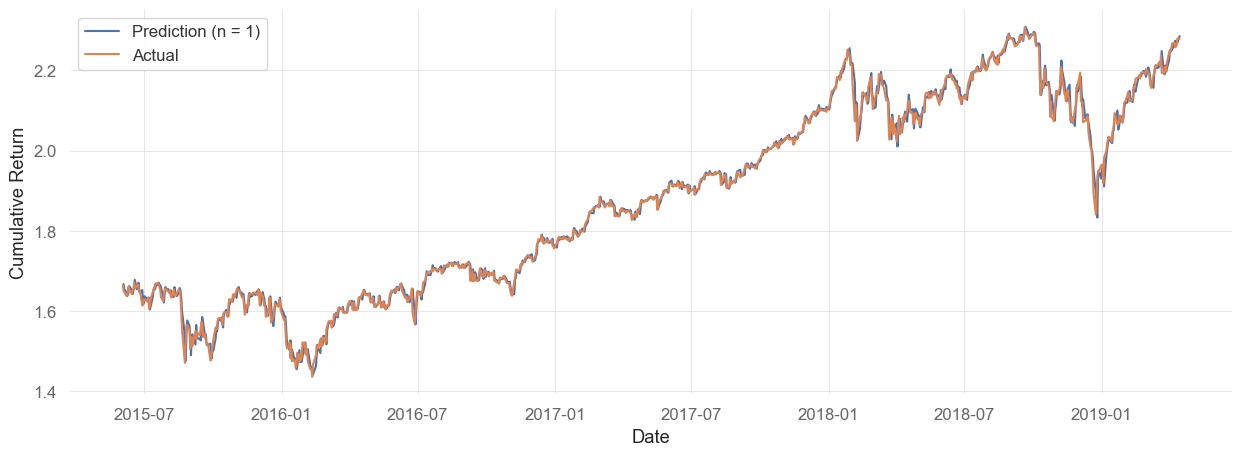

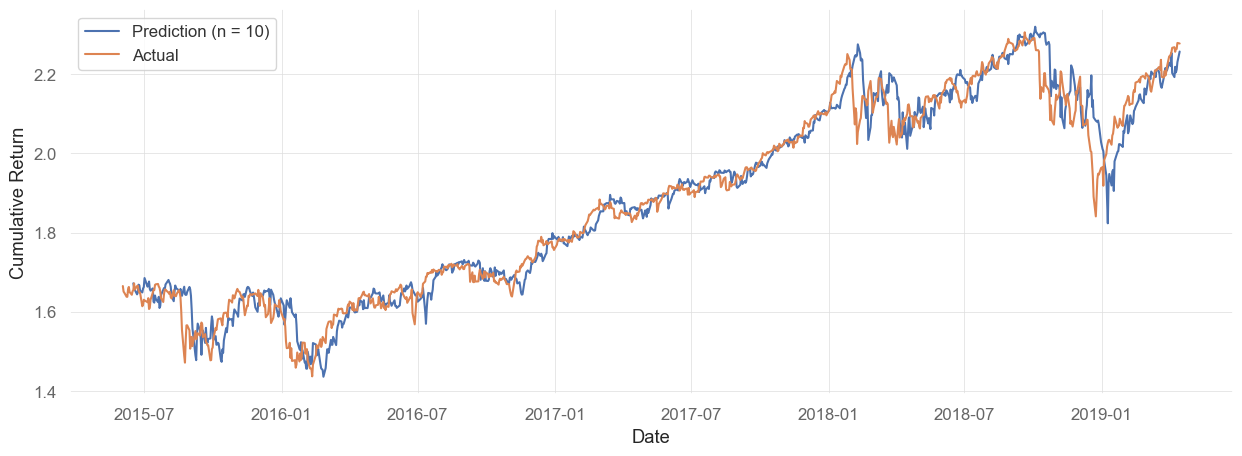

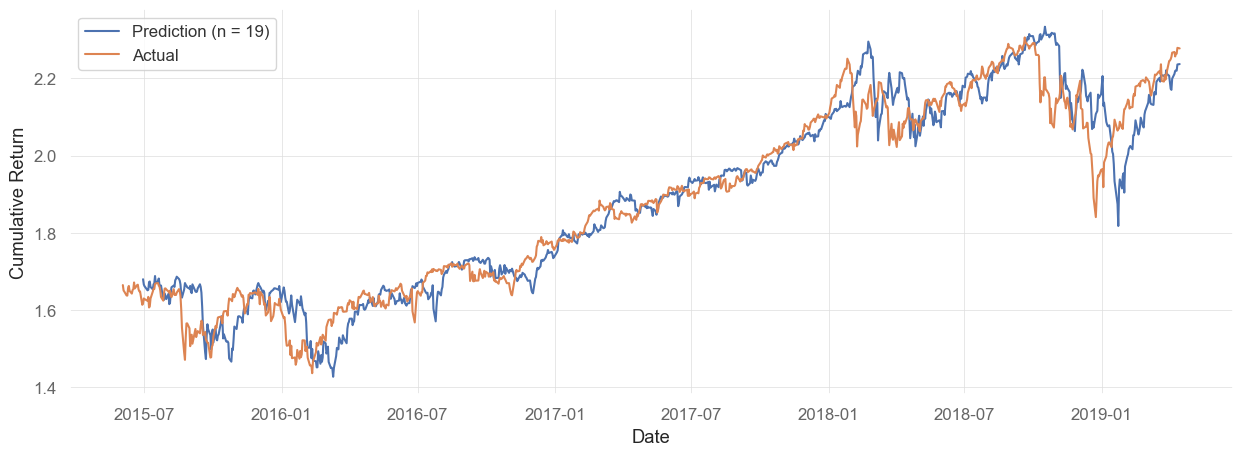

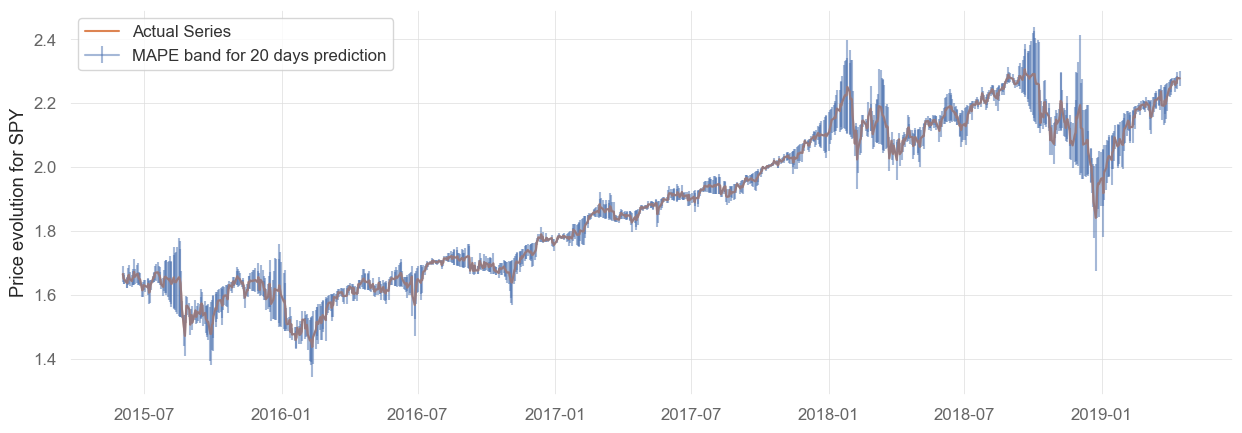

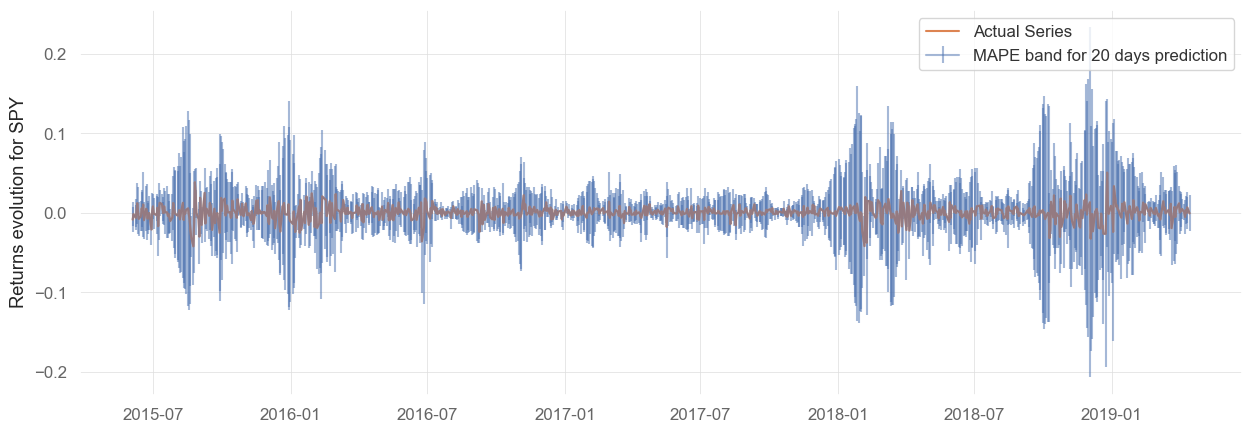

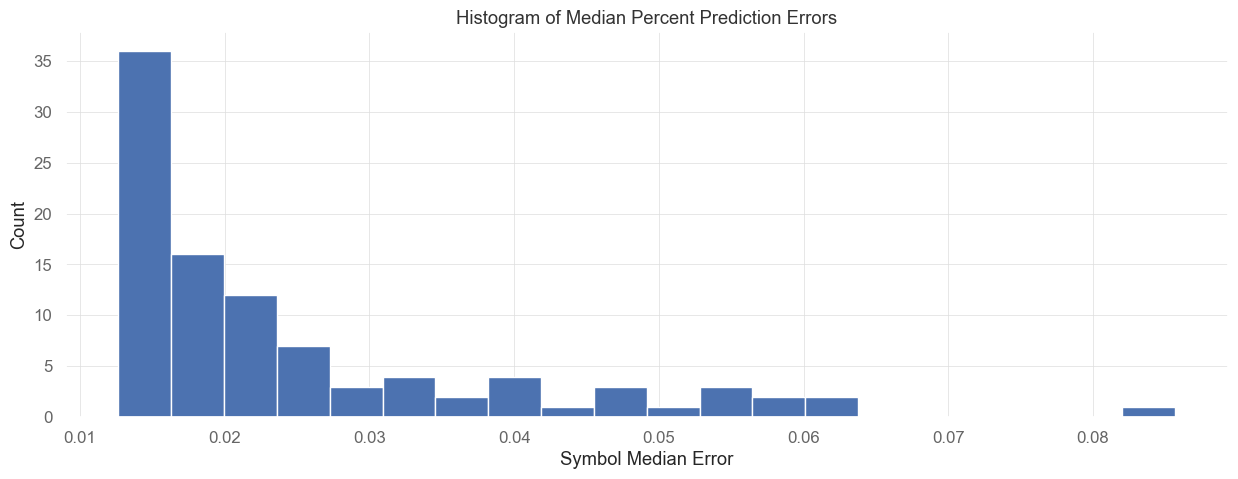

2024-11-07 10:22:39,293 - stock_logger - INFO - Finished predicting for order (0, 1, 2). Printing summary...


count    97.000000
mean      0.024885
std       0.014433
min       0.012650
25%       0.014470
50%       0.019447
75%       0.028209
max       0.085678
Name: 50%, dtype: float64
Median of Median Errors    0.019447
Mean of Median Errors      0.024885
Mean of Mean Errors        0.032296
dtype: float64


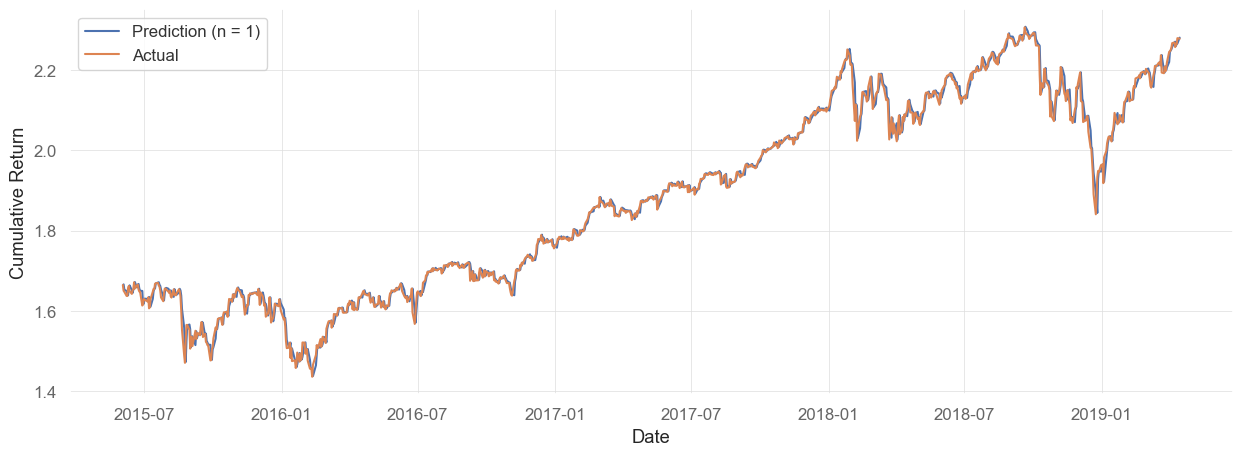

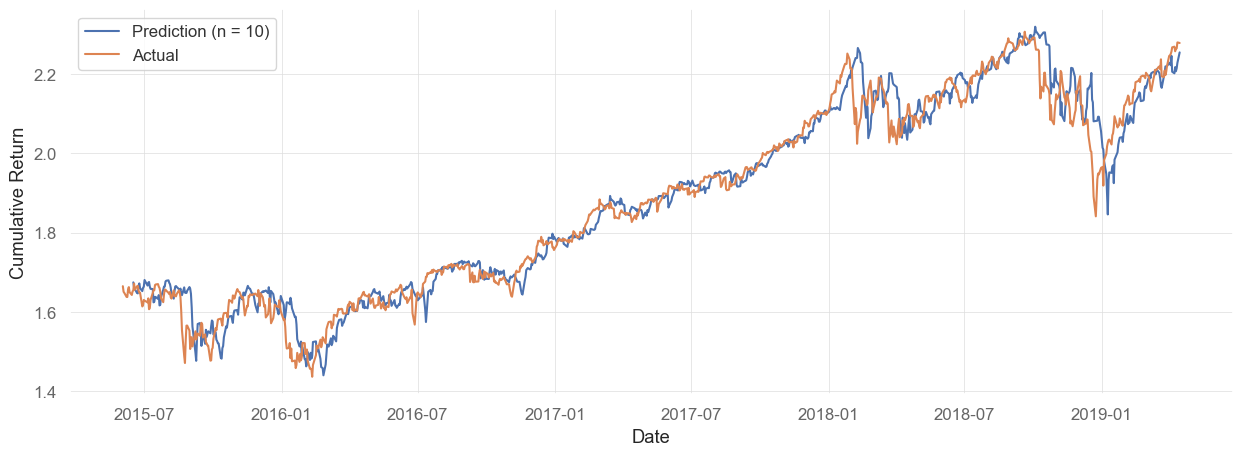

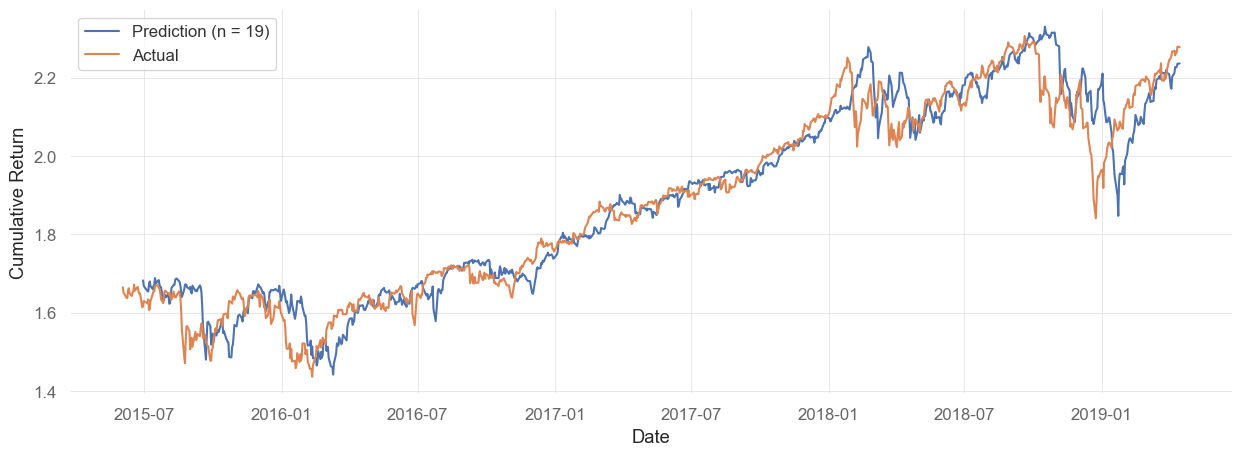

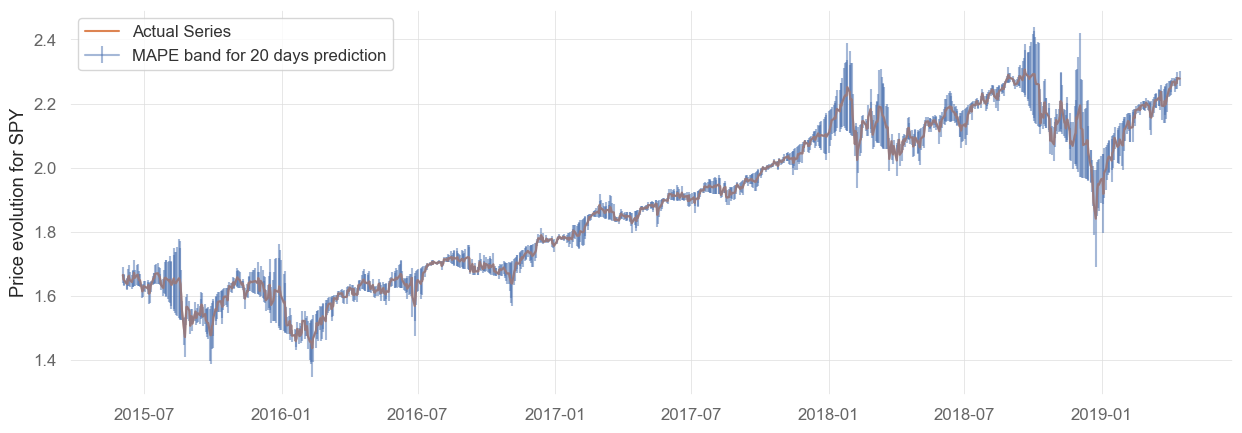

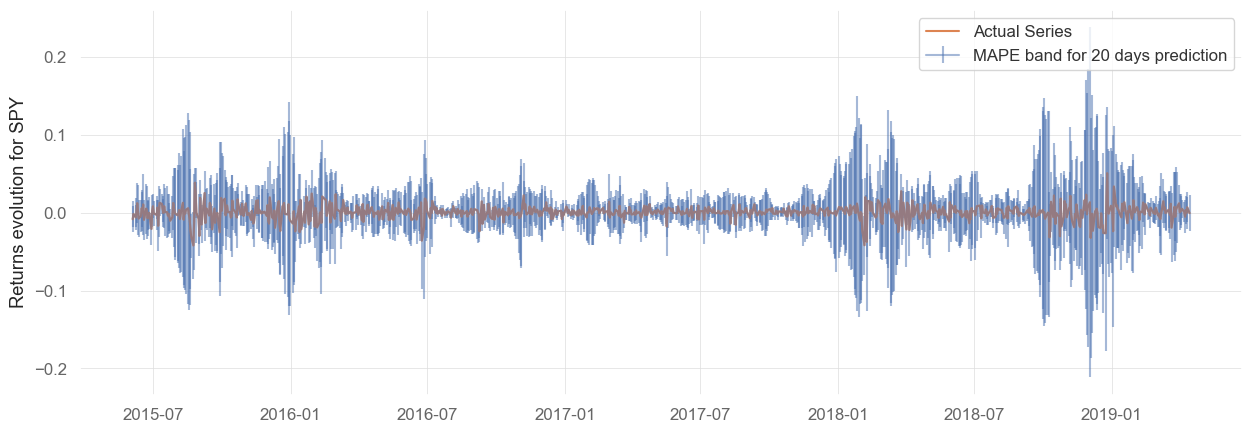

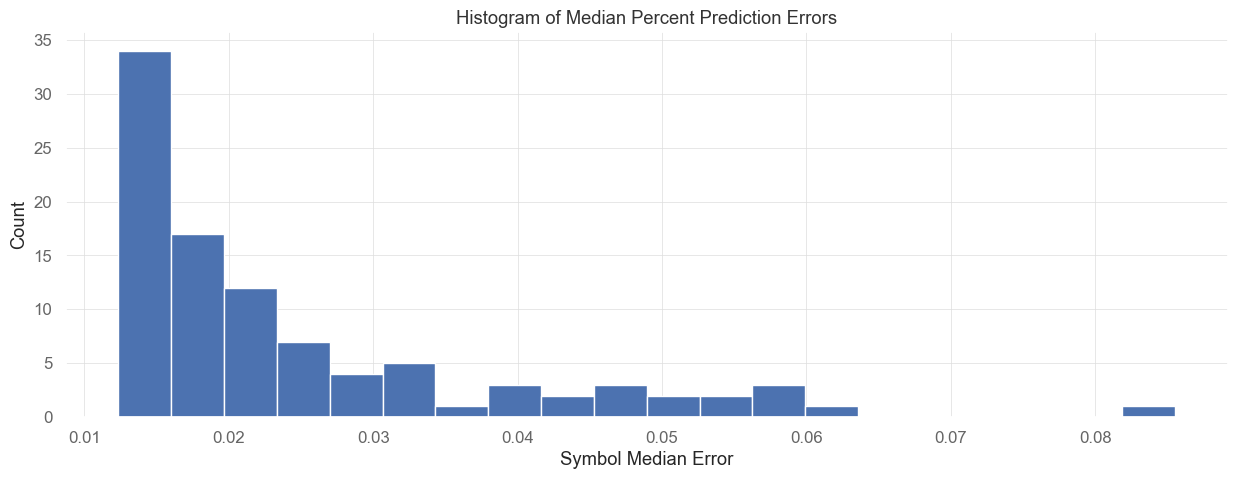

count    97.000000
mean      0.024602
std       0.014300
min       0.012348
25%       0.014570
50%       0.019262
75%       0.028311
max       0.085543
Name: 50%, dtype: float64
Median of Median Errors    0.019262
Mean of Median Errors      0.024602
Mean of Mean Errors        0.031819
dtype: float64


/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarn

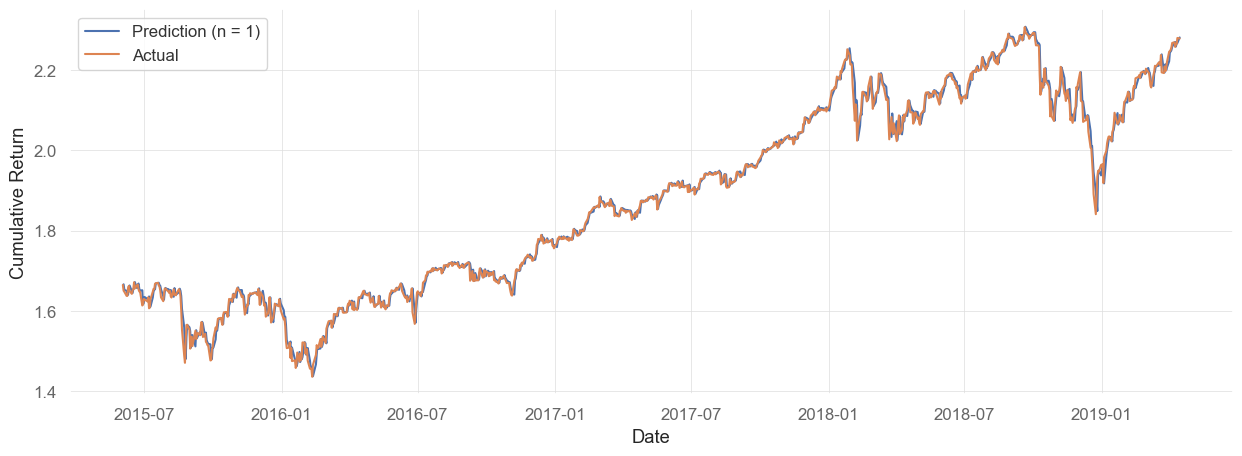

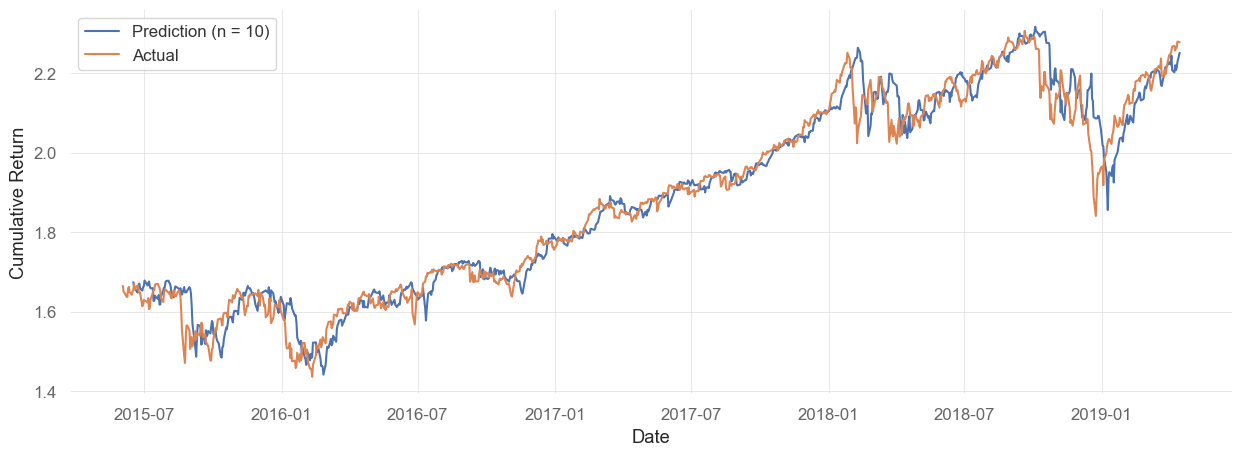

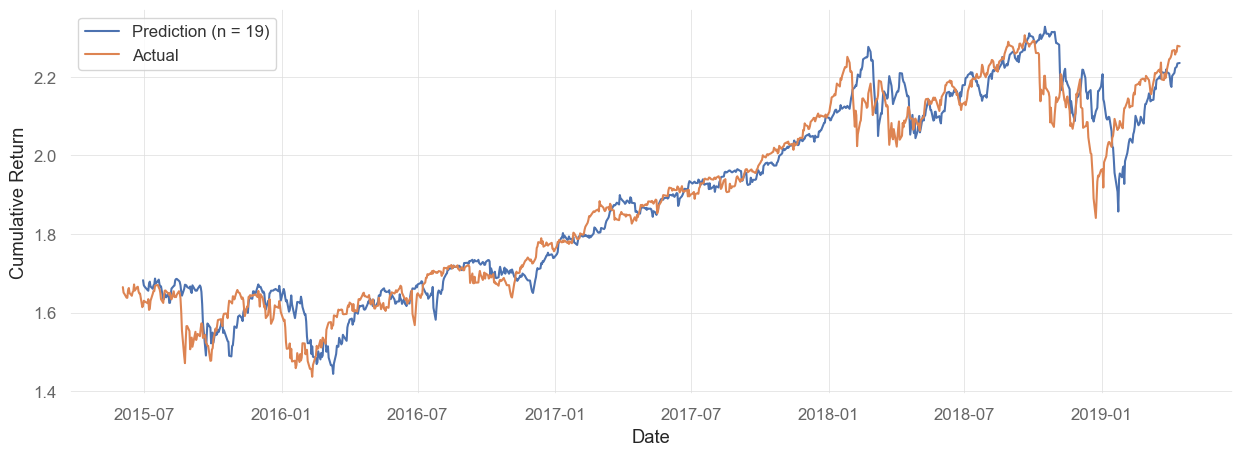

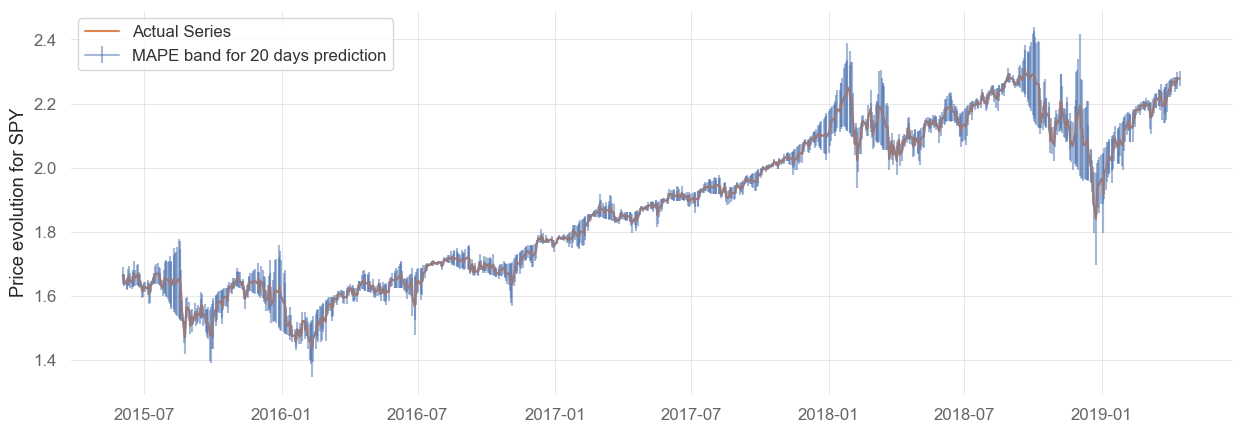

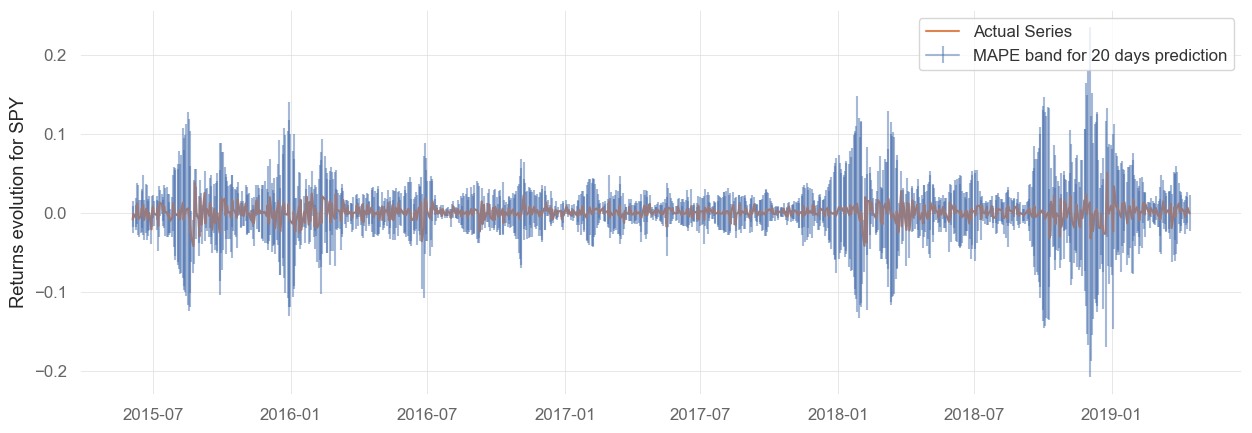

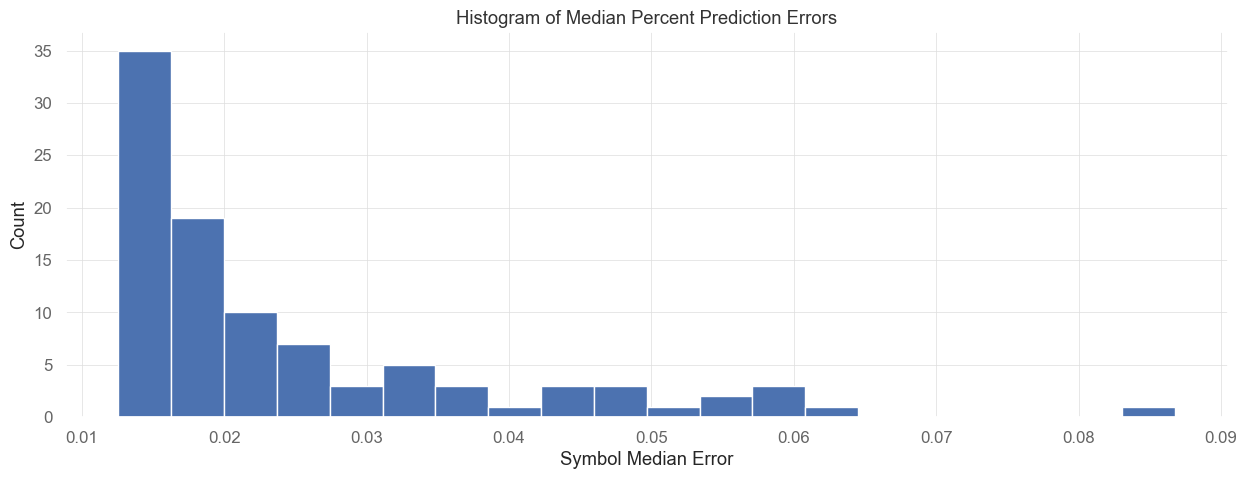

count    97.000000
mean      0.024610
std       0.014346
min       0.012575
25%       0.014481
50%       0.019200
75%       0.028330
max       0.086776
Name: 50%, dtype: float64
Median of Median Errors    0.019200
Mean of Median Errors      0.024610
Mean of Mean Errors        0.031837
dtype: float64


/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: Conver

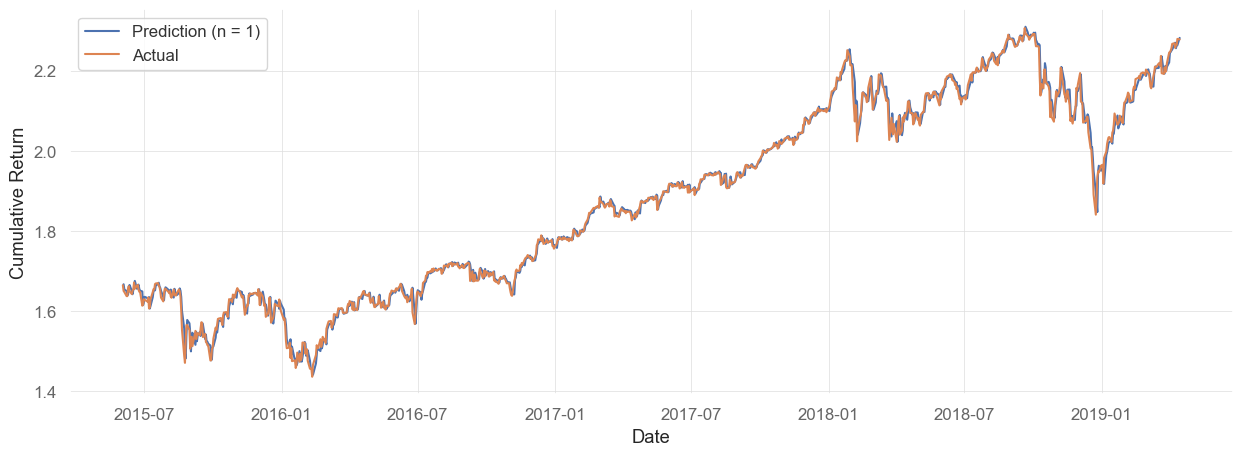

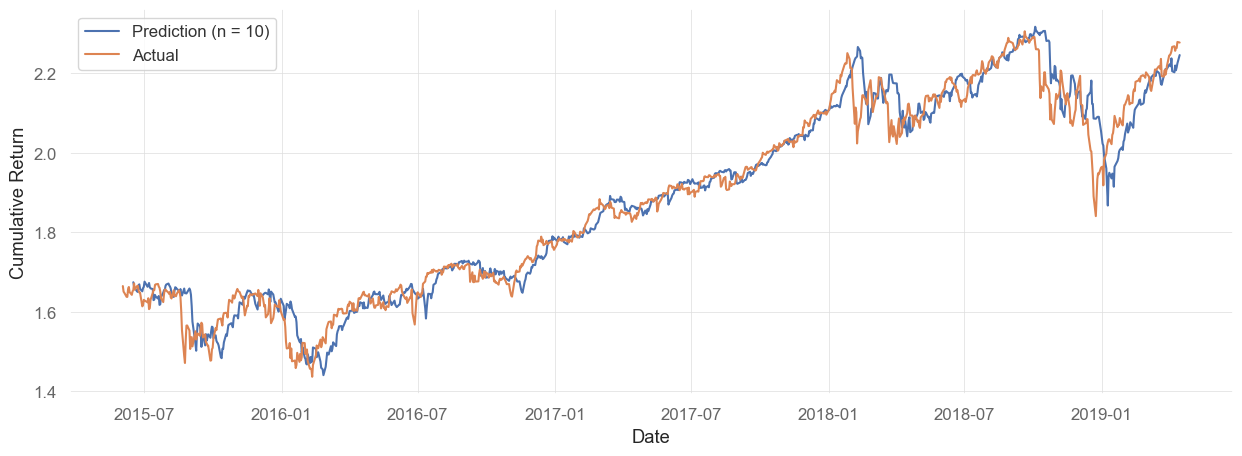

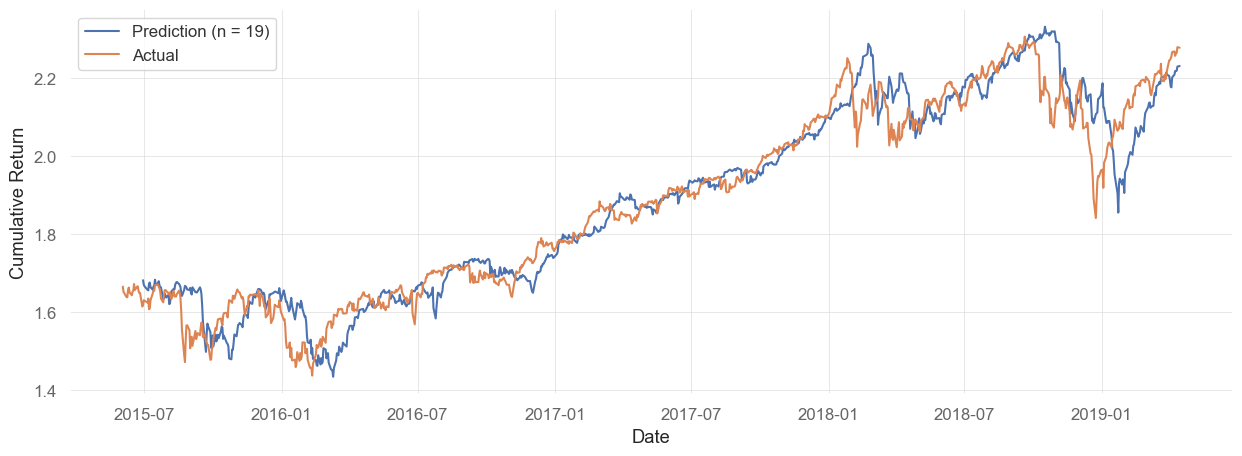

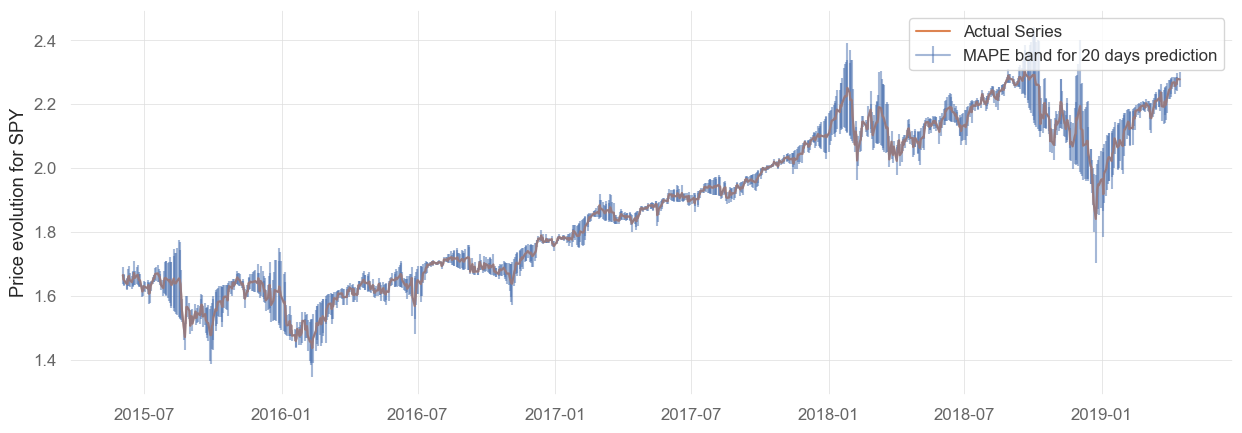

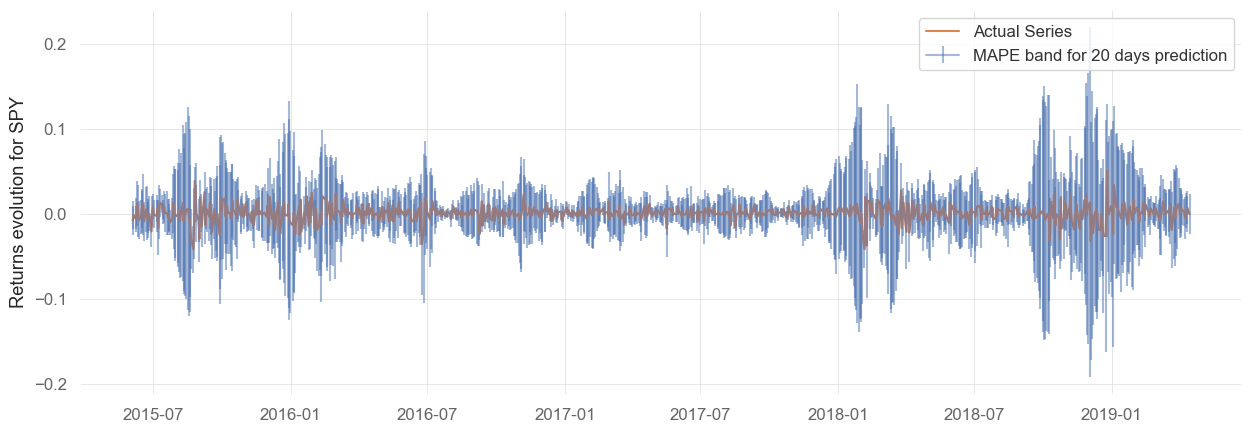

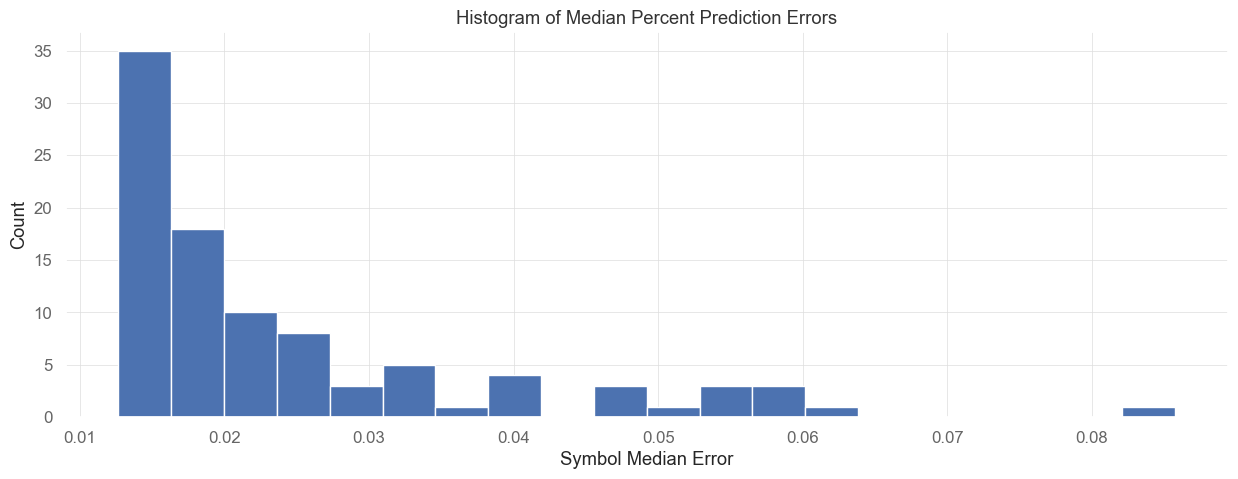

count    96.000000
mean      0.024724
std       0.014501
min       0.012658
25%       0.014198
50%       0.019461
75%       0.028043
max       0.085767
Name: 50%, dtype: float64
Median of Median Errors    0.019461
Mean of Median Errors      0.024724
Mean of Mean Errors        0.032153
dtype: float64


/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mops2/.cache/pypoetry/virtualenvs/stock-prediction-c80Ia0bK-py3.10/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarn

In [ ]:
df_results = None
for order in orders:
    predictions_checkpoint_name = (
        f"predictions_arima_{order[0]}_{order[1]}_{order[2]}.pkl"
    )

    if predictions_checkpoint_name in os.listdir():
        predictions_arima = pickle.load(open(predictions_checkpoint_name, "rb"))
    else:
        arima_model = UnivariateARIMAs(p=order[0], d=order[1], q=order[2])
        arima_model.fit(df_train.iloc[:i_predict_min, :])
        predictions_arima = arima_model.predict(
            df_train,
            index_start=i_predict_min,
            index_end=i_predict_max,
            n_steps_predict=w_size,
        )
        pickle.dump(predictions_arima, open(predictions_checkpoint_name, "wb"))
    logger.info(f"Finished predicting for order {order}. Printing summary...")
    ser_results = summary_analysis(
        df=df_train,
        n_predict=w_size,
        predictions=predictions_arima,
        actuals=actuals,
        index_start=i_predict_min,
        index_end=i_predict_max,
        symbol="SPY",
    )
    print(f"order {order}")
    print("------")
    if df_results is None:
        df_results = pd.DataFrame(ser_results).T
        df_results["order"] = str(order)
    else:
        df_res = pd.DataFrame(ser_results).T
        df_res["order"] = str(order)
        df_results = pd.concat([df_results, df_res], axis=0).reset_index(drop=True)
df_results.to_csv("results_arima.csv", index=False)